# Miscellaneous COVID-19 Data Analyses using New York Times Data

Data sources:

- <a href="https://github.com/nytimes/covid-19-data" target="_blank">Data from The New York Times, based on reports from state and local health agencies</a>.
  The data resides in a GitHub repository that is assumed to be checked out in subdirectory `data/nytimes/covid-19-data`.
- <a href="https://worldpopulationreview.com/states/" target="_blank">World Population Review</a> (for state population data).

The most up-to-date version of this notebook can be found in GitHub repository <https://github.com/bmc/covid19/>.


## Imports and constants

In [1]:
import matplotlib
import matplotlib.pyplot as p
import numpy as np
from datetime import datetime, timedelta, date
import csv
import os
import re
import math
from pprint import pprint
from lib.common import *

matplotlib.__version__

'3.2.1'

In [2]:
NYTIMES_DIR_PATH = 'data/nytimes/covid-19-data'
US_DATA = os.path.join(NYTIMES_DIR_PATH, 'us.csv')
US_STATE_DATA = os.path.join(NYTIMES_DIR_PATH, 'us-states.csv')
US_COUNTY_DATA = os.path.join(NYTIMES_DIR_PATH, 'us-counties.csv')

In [3]:
os.makedirs(IMAGES_PATH, exist_ok=True)
today = datetime.now().date()

## State population data

In [4]:
populations = load_united_states_population_data()
print(f"{populations['United States']:,}")

334,351,157


## Read the New York Times data

In [5]:
from dataclasses import dataclass

state_info = load_state_info()
county_info = load_county_info(state_info)

@dataclass(frozen=True)
class NYTStateData:
    state: str
    fips: int
    deaths: int
    cases: int
    present_in_data: bool


@dataclass(frozen=True)
class NYTCountyData:
    state: str
    county: str
    fips: int
    deaths: int
    cases: int
    present_in_data: bool


DATE_FORMAT = '%Y-%m-%d' # for parsing with datetime.strptime

def read_nyt_state_data(starting_date=date(year=2020, month=4, day=12)):
    """
    Read and load the NY Times US-wide data. Returns a dictionary indexed by date. The
    value for each key is another dictionary indexed by full state name and populated by
    by NYTStateData values.

    In the data file, states can be missing from the data for a particular date. If that happens,
    the NYTStateData object will contains zeros for deaths and cases, and present_in_data will be
    set to False.
    """
    results = {}
    with open(US_STATE_DATA, mode='r', encoding='UTF-8') as f:
        for row in csv.DictReader(f):
            date = datetime.strptime(row['date'], DATE_FORMAT).date()
            if date < starting_date:
                continue

            state = row['state']
            data_for_date = results.get(date, {})
            data_for_date[state] = NYTStateData(
                state=state,
                fips=csv_int_field(row, 'fips'),
                deaths=csv_int_field(row, 'deaths'),
                cases=csv_int_field(row, 'cases'),
                present_in_data=True
            )
            results[date] = data_for_date

    # Post-process each row, filling in missing counties.

    for date in results.keys():
        for state in state_info.keys():
            data_for_date = results[date]
            if data_for_date.get(state) is None:
                data_for_date[state] = NYTStateData(
                    state=state,
                    fips=state_info[state].fips_code,
                    deaths=0,
                    cases=0,
                    present_in_data=False
                )

    return results

def read_nyt_county_data(starting_date=date(year=2020, month=3, day=1)):
    """
    Read and the NY Times county data file. Returns nested dictionaries
    in this format:
    
        { state1: {date: {county1: NYTCountyData,
                          county2: NYTCountyData,
                          ...
                          },
                   date: {count1: NYTCountyData,
                          count2: NYTCountyData,
                          ...
                          },
                   ...
                   },
          ...
        }

    In the data file, county data can be missing from the data for a particular date.
    This function attempts to fill those in, using NYTCountyData records with deaths
    and cases set to 0, and present_in_data set to False.
    """
    results = {}
    with open(US_COUNTY_DATA, mode='r', encoding='UTF-8') as f:
        for row in csv.DictReader(f):
            date = datetime.strptime(row['date'], DATE_FORMAT).date()
            if date < starting_date:
                continue

            state = row['state']
            data_for_state = results.get(state, {})
            
            data_for_date = data_for_state.get(date, {})

            county = row['county']
            data_for_date[county] = NYTCountyData(
                state=state,
                county=county,
                fips=csv_int_field(row, 'fips'),
                deaths=csv_int_field(row, 'deaths'),
                cases=csv_int_field(row, 'cases'),
                present_in_data=True
            )

            data_for_state[date] = data_for_date

            results[state] = data_for_state

    # Post-process each row, filling in missing counties.

    for state, state_data in results.items():
        counties_in_state = county_info[state].keys()
        for date in state_data.keys():
            data_for_date = state_data[date]
            for county in counties_in_state:
                if data_for_date.get(county) is None:
                    data_for_date[county] = NYTCountyData(
                        state=state,
                        county=county,
                        fips=state_info[state].fips_code,
                        deaths=0,
                        cases=0,
                        present_in_data=False
                    )

    return results

In [6]:
# This load can take a little while.
county_data = read_nyt_county_data()

In [7]:
nyt_data = read_nyt_state_data()
print(f"Read data for {len(nyt_data)} days.")
nyt_starting_date = min(nyt_data.keys())
nyt_ending_date = max(nyt_data.keys())
print(f"Starting date: {datestr(nyt_starting_date, include_year=True)}")
print(f"Ending date: {datestr(nyt_ending_date, include_year=True)}")

Read data for 88 days.
Starting date: 04/12/2020
Ending date: 07/08/2020


In [8]:
dates_in_order = sorted(nyt_data.keys())

## Deaths versus cases across the US

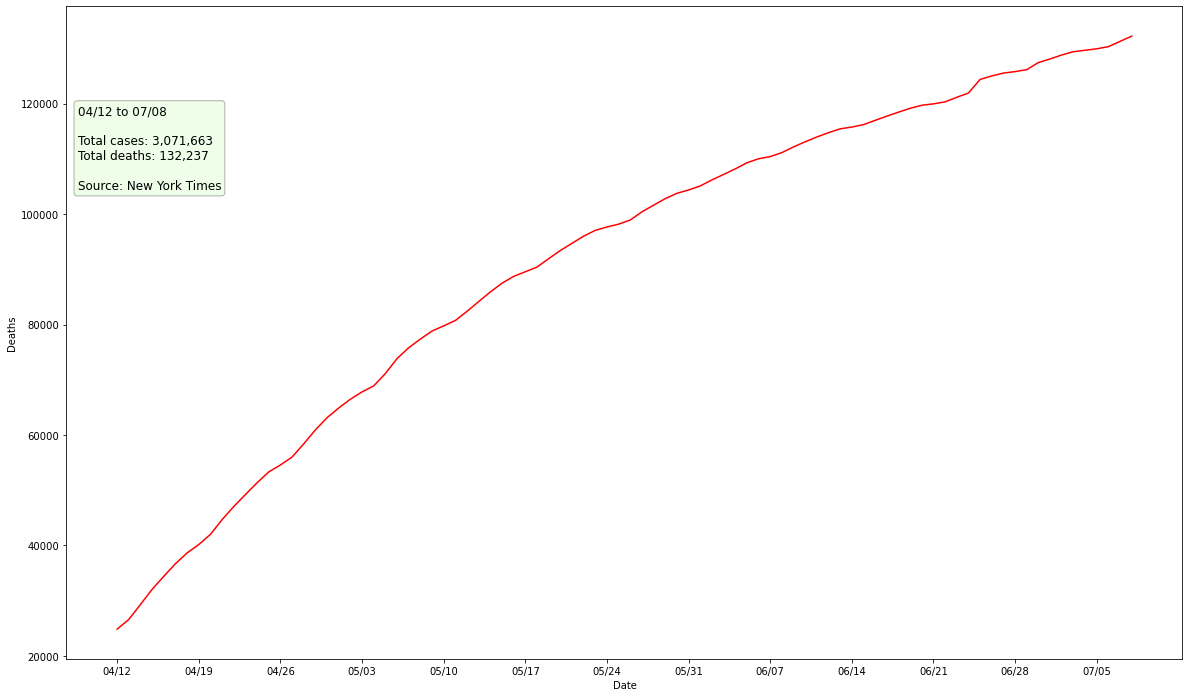

In [9]:
# Line chart plots of deaths and cases

x_dates = [datestr(d) for d in dates_in_order]
total_deaths = []
total_cases = []
total_recovered = []

for i, date in enumerate(dates_in_order):
    data = nyt_data[date]
    deaths = sum([d.deaths for state, d in data.items()])
    cases = sum([d.cases for state, d in data.items()])
    total_deaths.append(deaths)
    total_cases.append(cases)

fig, ax = p.subplots(figsize=(20, 12))
ax.plot(x_dates, total_deaths, color='red', label='Deaths')

ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
text = f"""{x_dates[0]} to {x_dates[-1]}

Total cases: {total_cases[-1]:,}
Total deaths: {total_deaths[-1]:,}

Source: New York Times"""
textbox(ax, 0.01, 0.85, text)
fig.savefig(os.path.join(IMAGES_PATH, 'nyt-us-deaths.png'))

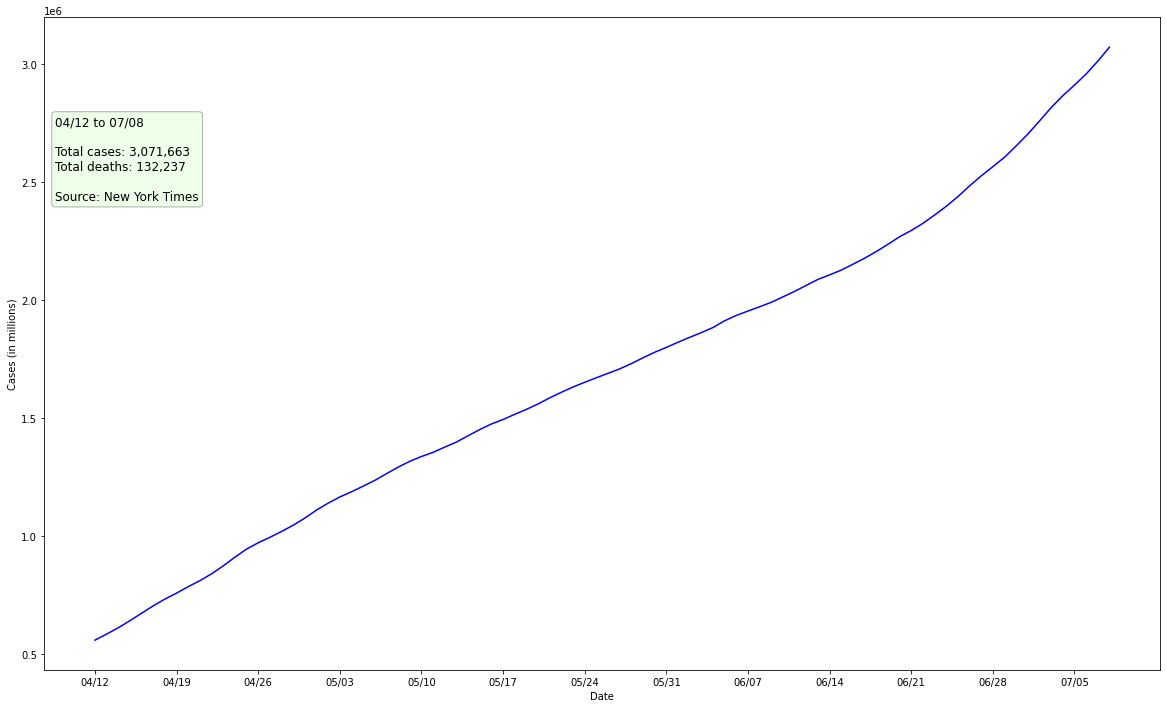

In [10]:
fig, ax = p.subplots(figsize=(20, 12))
ax.plot(x_dates, total_cases, color='blue', label='Cases')

ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days
ax.set_xlabel('Date')
ax.set_ylabel('Cases (in millions)')

#ymax, stride = determine_ymax_and_stride(total_cases[-1])
#ax.set_yticks(list(range(0, ymax))[::stride])

text = f"""{x_dates[0]} to {x_dates[-1]}

Total cases: {total_cases[-1]:,}
Total deaths: {total_deaths[-1]:,}

Source: New York Times"""
textbox(ax, 0.01, 0.85, text)
fig.savefig(os.path.join(IMAGES_PATH, 'nyt-us-cases.png'))

### Just the past week

In [11]:
week_delta = timedelta(days=6)
six_days_prior = nyt_ending_date - week_delta
print(datestr(six_days_prior, include_year=True))
print(datestr(nyt_ending_date, include_year=True))

07/02/2020
07/08/2020


U.S. Deaths: 07/02 through 07/08

Total deaths on 07/02: 128,826
Total deaths on 07/08: 132,237
Deaths during period: 4,134

Source: New York Times


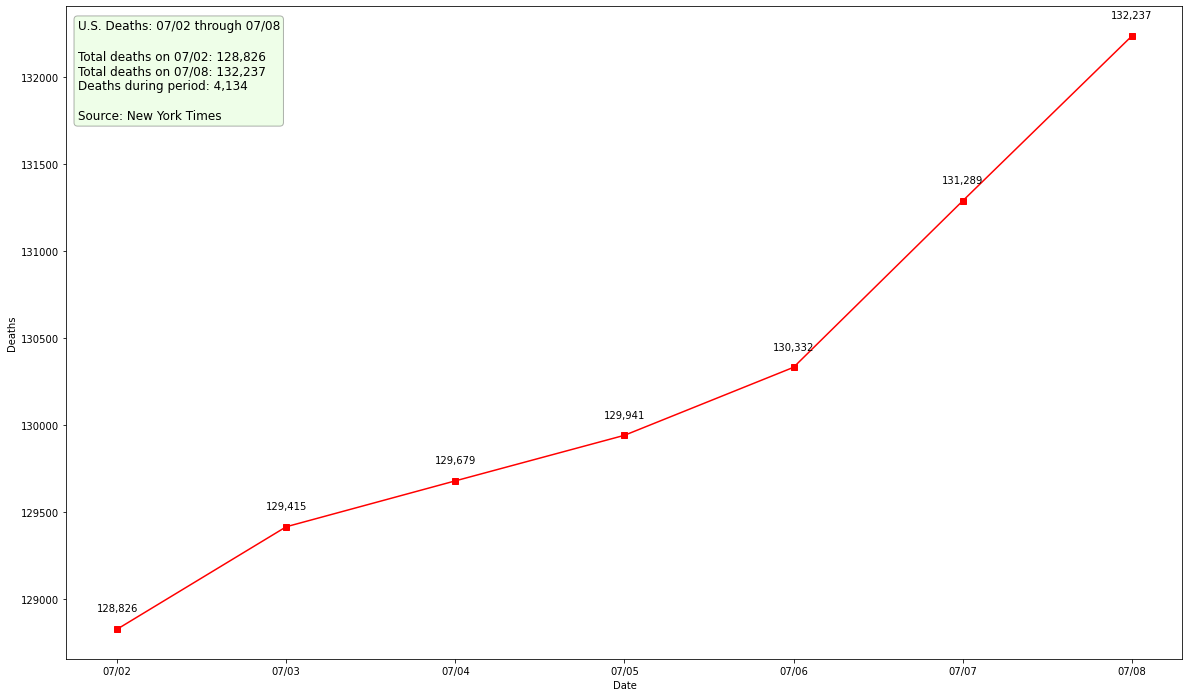

In [12]:
fig, ax = p.subplots(figsize=(20, 12))
x_dates = [datestr(d) for d in dates_in_order if d >= six_days_prior]
deaths_a_week_ago = sum([d.deaths for state, d in nyt_data[nyt_ending_date - timedelta(days=7)].items()])
total_deaths = []
total_cases = []
total_recovered = []

for date in dates_in_order:
    if date < six_days_prior:
        continue
    data = nyt_data[date]
    total_deaths.append(sum([d.deaths for state, d in data.items()]))
    total_cases.append(sum([d.cases for state, d in data.items()]))

ax.plot(x_dates, total_deaths, color='red', label='Deaths', marker='s')
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')

# Put the actual numbers on the chart.
for x, y in zip(x_dates, total_deaths):
    label = f"{y:,}"
    # The xytext values are absolute — and kind of fiddly.
    ax.annotate(label, (x, y), ha='center', xytext=(x, y+100))

text = f"""U.S. Deaths: {x_dates[0]} through {x_dates[-1]}

Total deaths on {x_dates[0]}: {total_deaths[0]:,}
Total deaths on {x_dates[-1]}: {total_deaths[-1]:,}
Deaths during period: {(total_deaths[-1] - deaths_a_week_ago):,}

Source: New York Times"""
textbox(ax, 0.01, 0.98, text)
fig.savefig(os.path.join(IMAGES_PATH, 'past-week.png'))
print(text)

## Individual States

In [13]:
def plot_state(state, color='red', fig=None, ax=None, image_file=None, metrics={MetricType.DEATHS}, xy_text=(0.01, 0.98),
               start_date=None):
    if ax is None:
        fig, ax = p.subplots(figsize=(20, 12))

    dates = dates_in_order
    if start_date is not None:
        dates = [d for d in dates_in_order if d >= start_date]

    x_dates = [datestr(d) for d in dates]
    total_deaths = []
    total_cases = []

    for date in dates:
        data = nyt_data[date][state]
        total_deaths.append(data.deaths)
        total_cases.append(data.cases)

    max_y = 0
    max_deaths = total_deaths[-1]
    max_cases = total_cases[-1]
    y_labels = []

    if MetricType.DEATHS in metrics:
        ax.plot(x_dates, total_deaths, color=color, label='Deaths')
        max_y = max(max_y, max_deaths)
        y_labels.append('Deaths')

    if MetricType.CASES in metrics:
        ax.plot(x_dates, total_cases, color='blue', label='Cases')
        max_y = max(max_y, max_cases)
        y_labels.append('Cases')

    if MetricType.RECOVERIES in metrics:
        print('Warning: Plotting recoveries is not currently supported.')

    if len(dates) > 21:
        ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days
    y_label = ' and '.join(y_labels)
    ymax, stride = determine_ymax_and_stride(max_y)
    ax.set_yticks(range(0, ymax)[::stride])
    ax.set_xlabel('Date')
    ax.set_ylabel(y_label)
    if len(metrics) > 1:
        ax.legend()
    text = f"""{state}: {x_dates[0]} to {x_dates[-1]}

Total cases: {total_cases[-1]:,}
Total deaths: {max_deaths:,}

Source: New York Times"""
    x, y = xy_text
    textbox(ax, x, y, text)
    if image_file is not None:
        fig.savefig(os.path.join(IMAGES_PATH, image_file))
        
    return (fig, ax)

### Pennsylvania

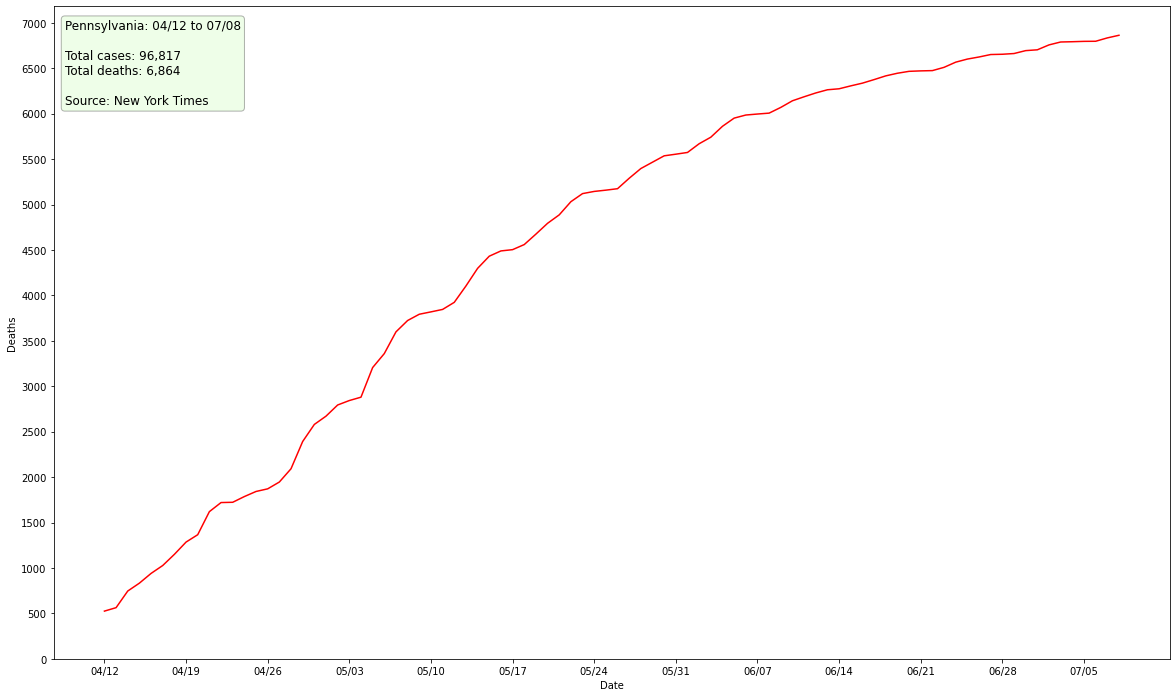

In [14]:
fig, ax = plot_state('Pennsylvania', image_file="nyt-pa-deaths.png")

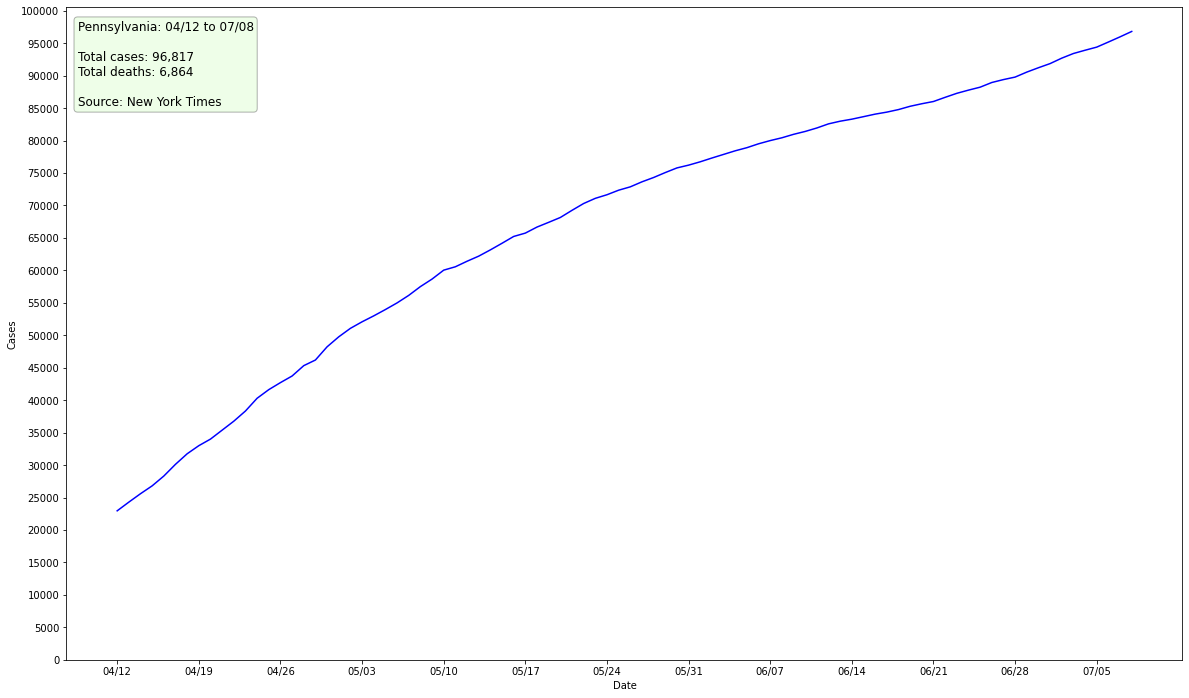

In [15]:
fig, ax = plot_state('Pennsylvania', image_file="nyt-pa-cases.png", metrics={MetricType.CASES})

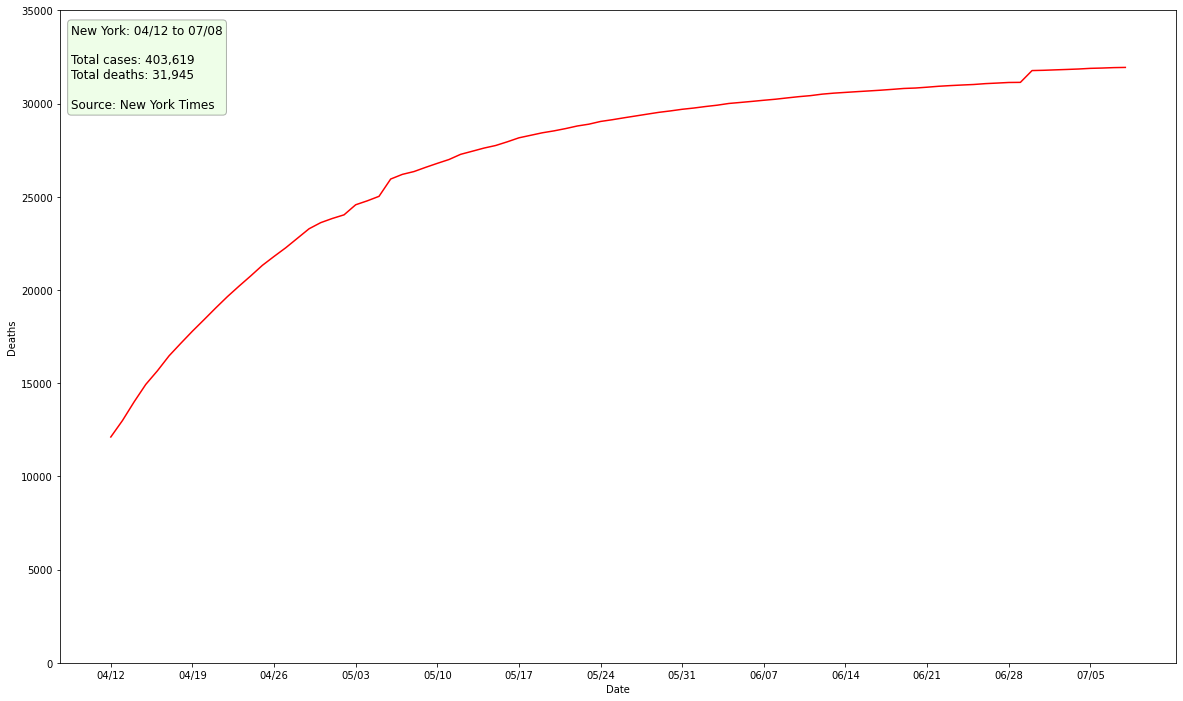

In [16]:
ax, fig = plot_state('New York', image_file="nyt-ny-deaths.png")

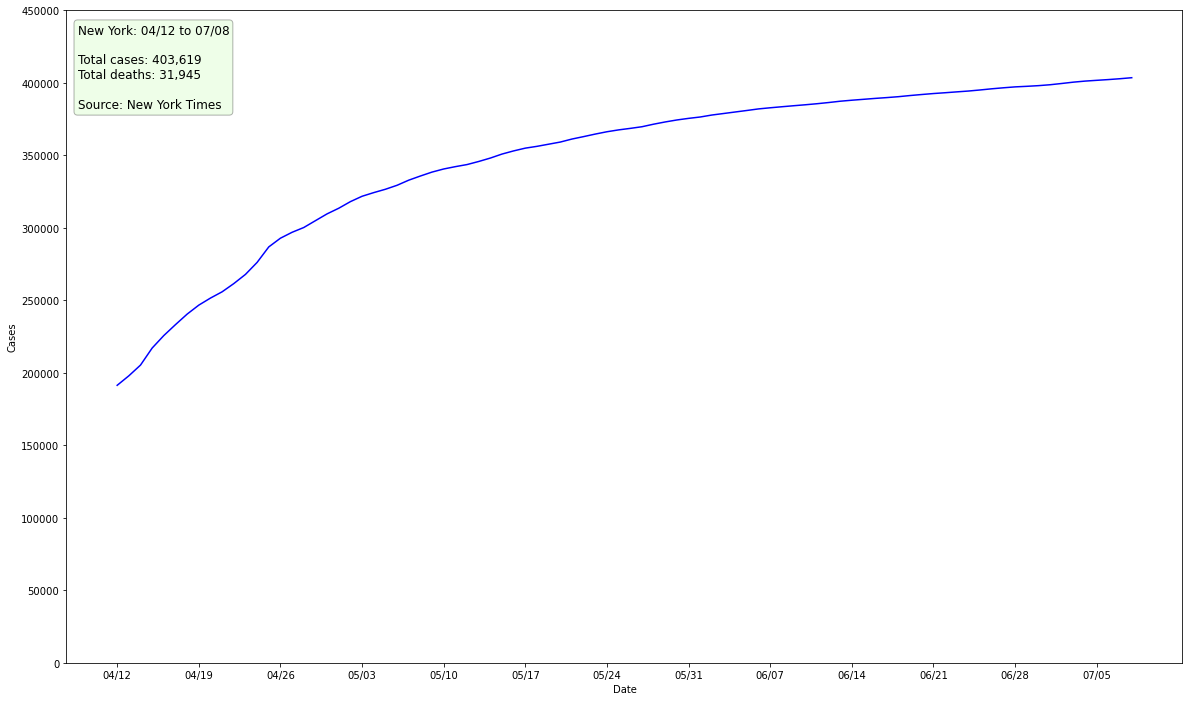

In [17]:
ax, fig = plot_state('New York', image_file="nyt-ny-cases.png", metrics={MetricType.CASES})

### Washington

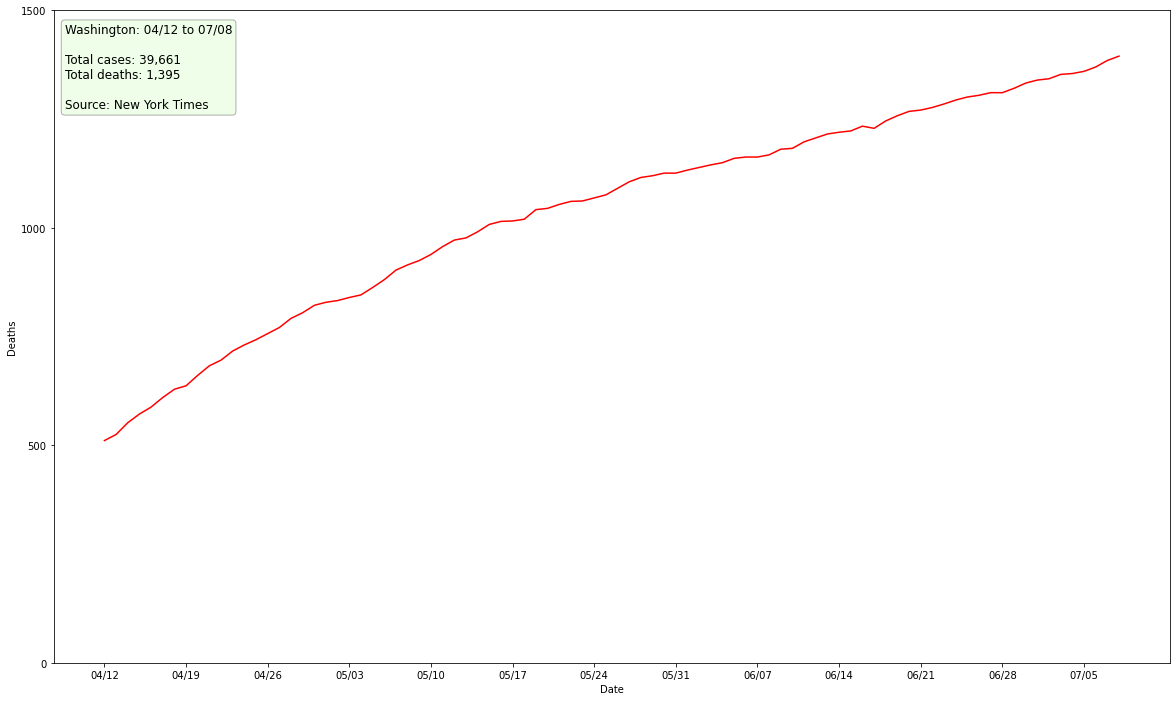

In [18]:
fig, ax = plot_state('Washington', image_file="nyt-wa-deaths.png")

### Delaware

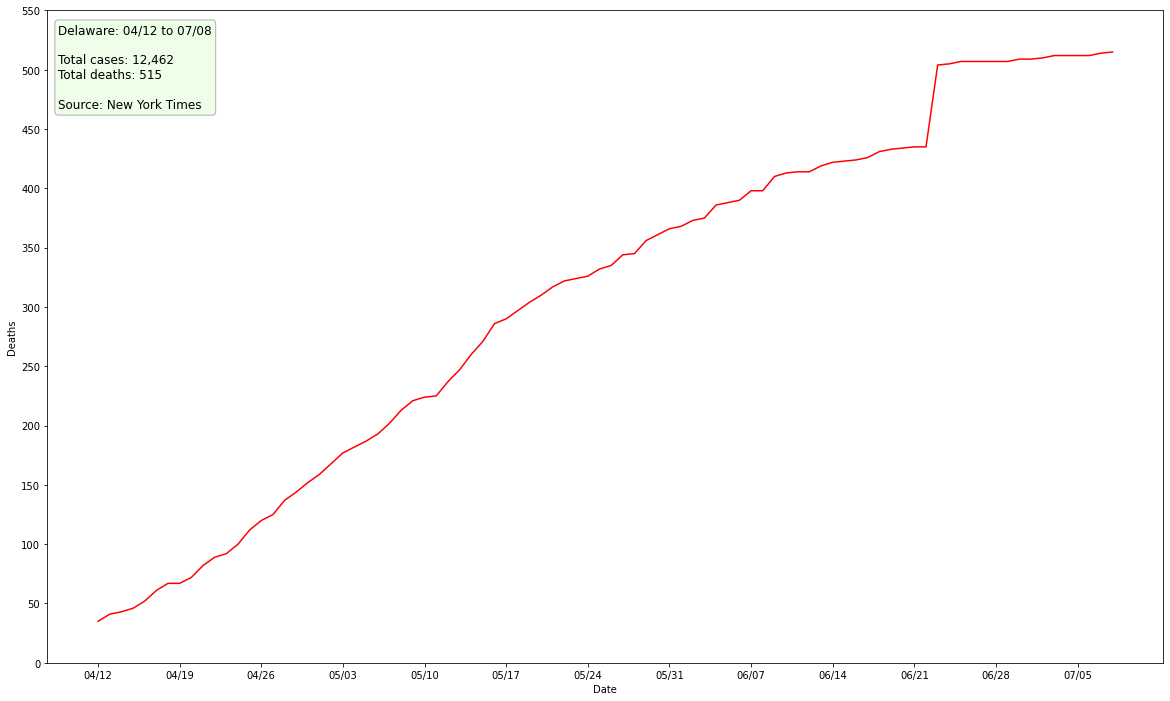

In [19]:
fig, ax = plot_state('Delaware', image_file='nyt-de-deaths.png')

### Texas

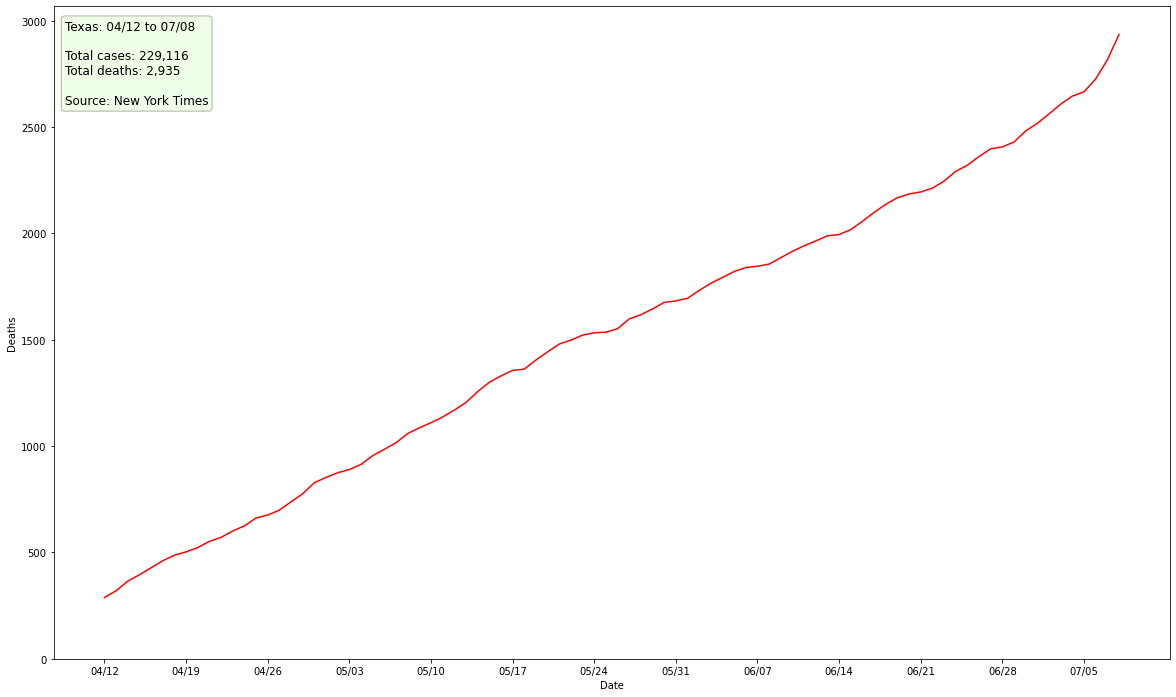

In [20]:
ax, fig = plot_state('Texas', image_file="nyt-tx-deaths.png")

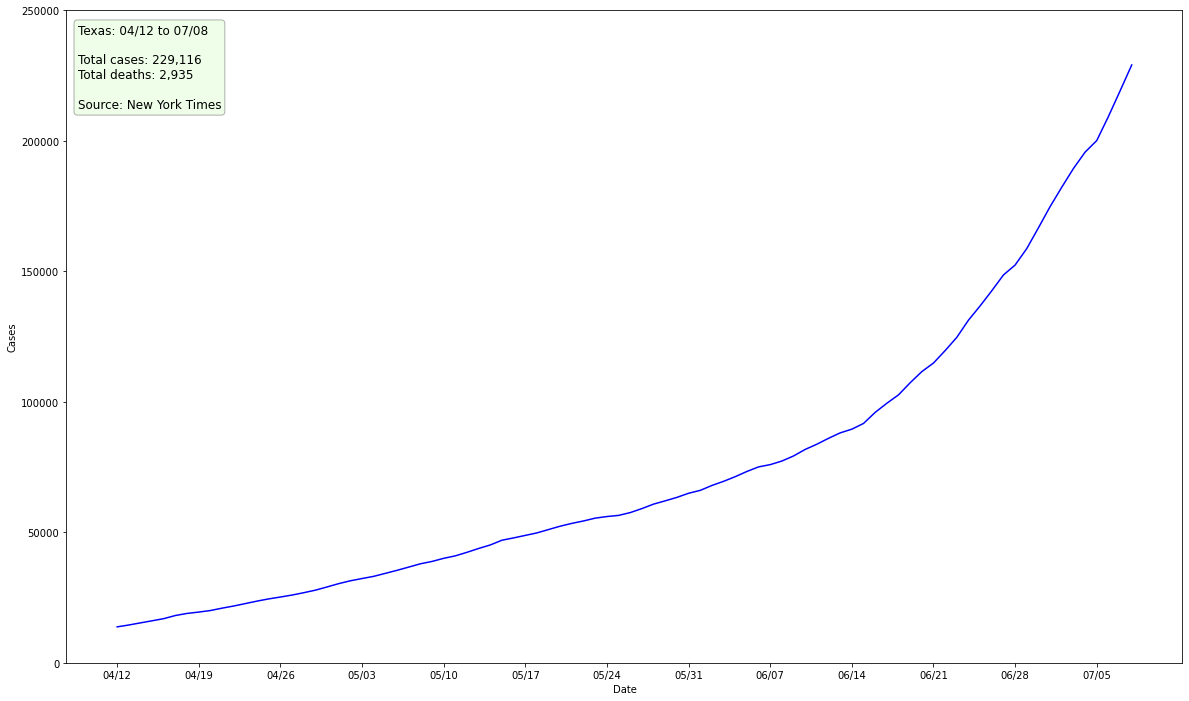

In [21]:
ax, fig = plot_state('Texas', image_file="nyt-tx-cases.png", metrics={MetricType.CASES})

### Georgia

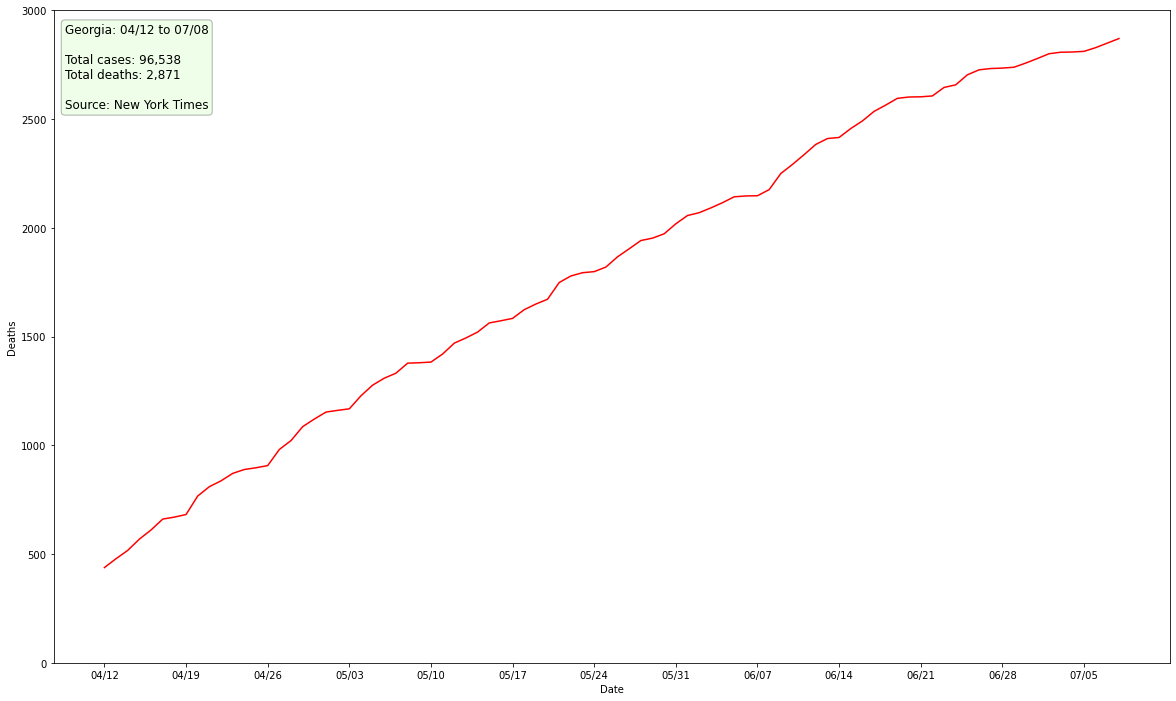

In [22]:
ax, fig = plot_state('Georgia', image_file="ga.png")

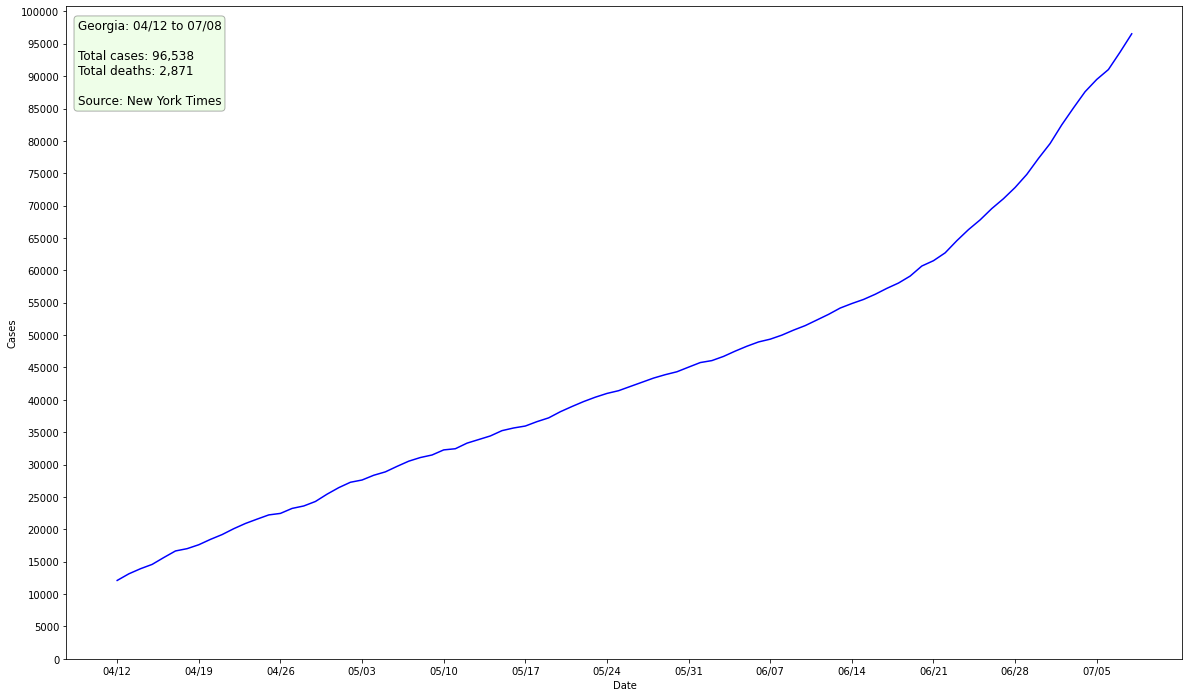

In [23]:
ax, fig = plot_state('Georgia', image_file="nyt-ga-cases.png", metrics={MetricType.CASES})

### Mississippi

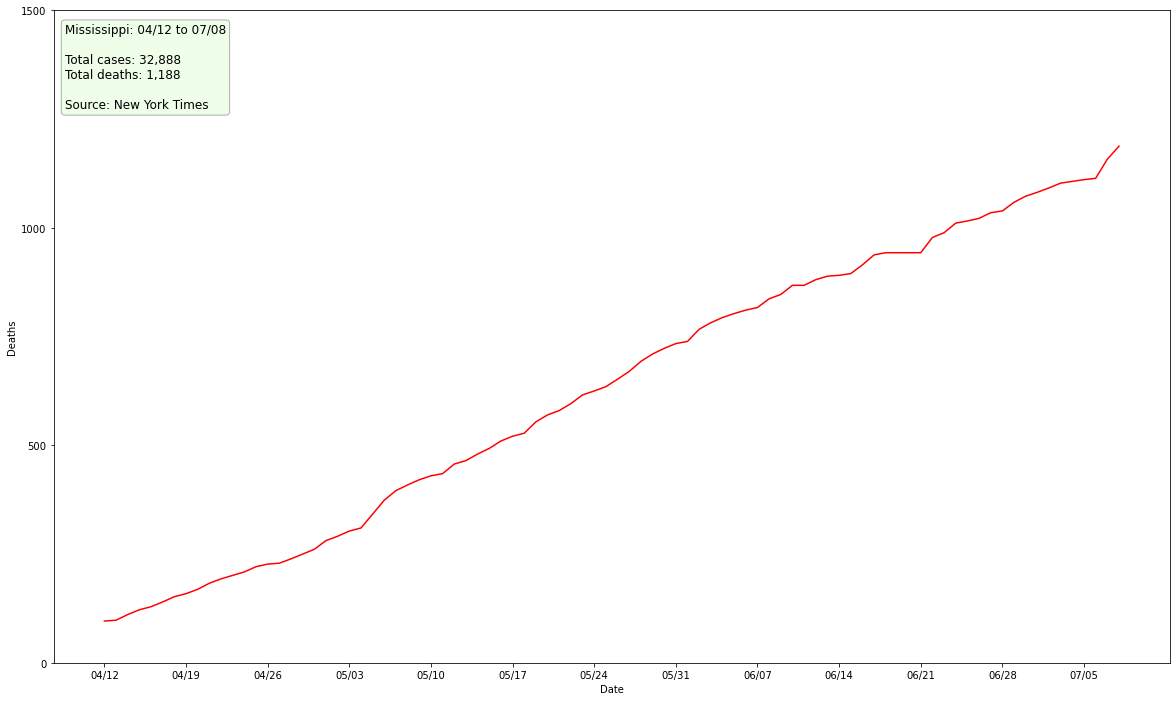

In [24]:
ax, fig = plot_state('Mississippi', image_file="nyt-ms-deaths.png")

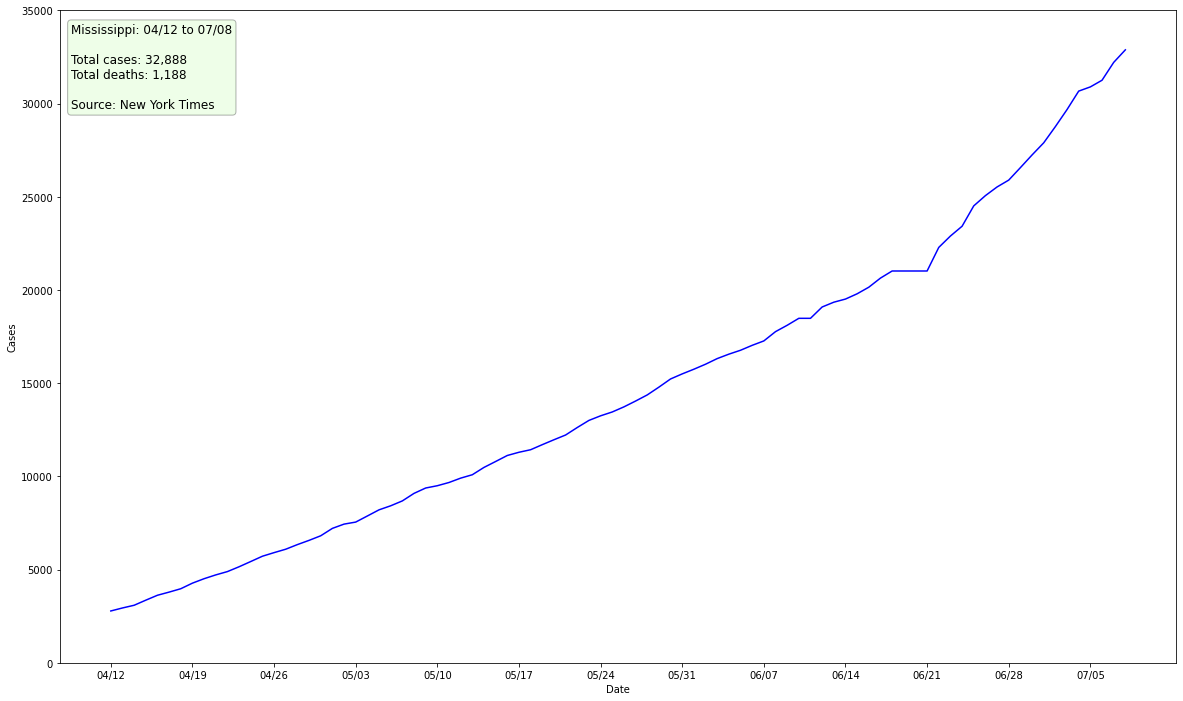

In [25]:
ax, fig = plot_state('Mississippi', image_file="nyt-ms-cases.png", metrics={MetricType.CASES})

### Arizona

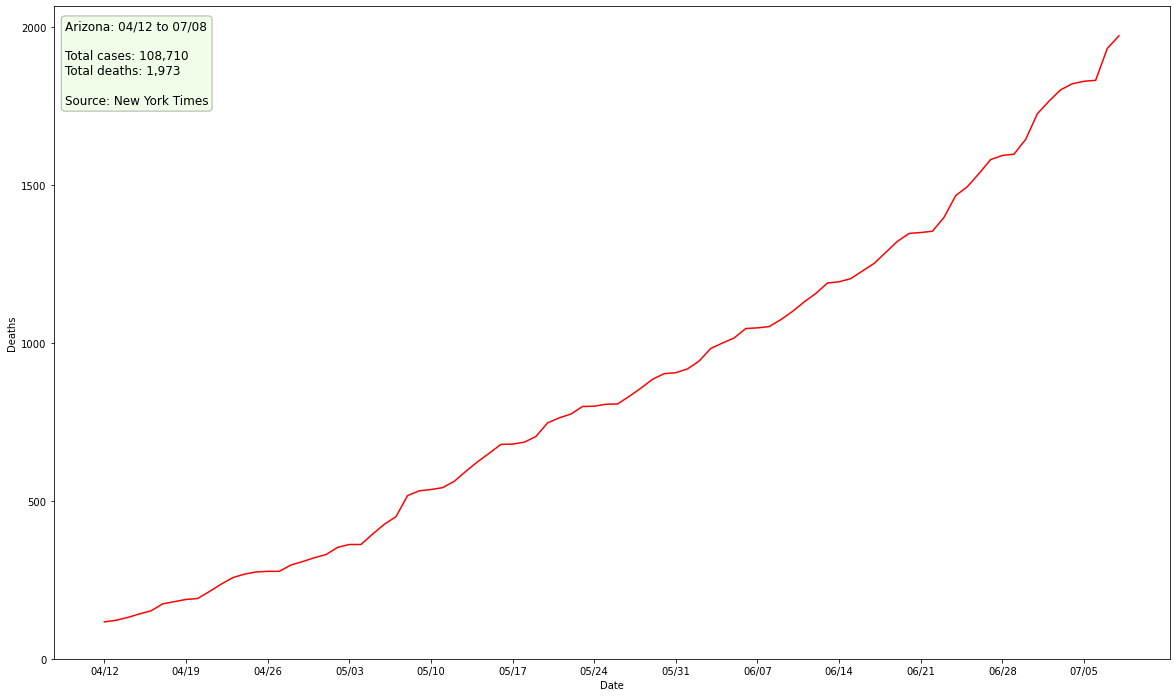

In [26]:
ax, fig = plot_state('Arizona', image_file="nyt-az-deaths.png")

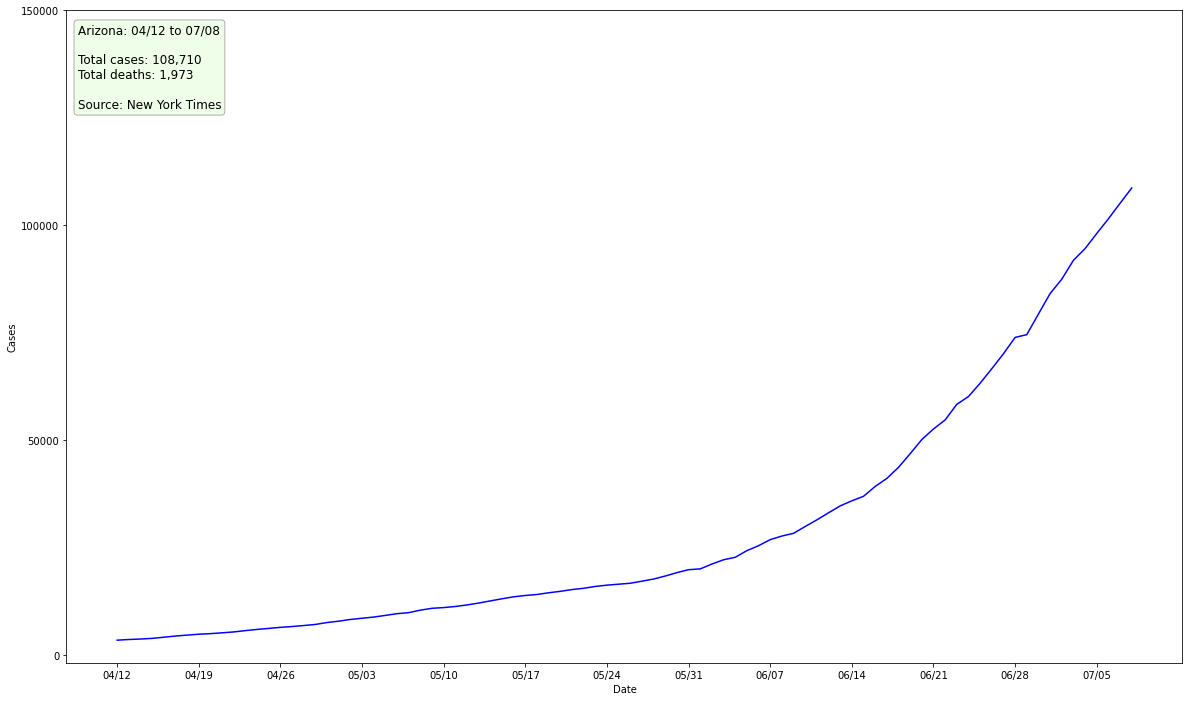

In [27]:
ax, fig = plot_state('Arizona', image_file="nyt-az-cases.png", metrics={MetricType.CASES})

### Multistate

In [28]:
XY_TEXT_DEFAULT = (0.01, 0.98)
def plot_states(jhu_data, states, xy_text=XY_TEXT_DEFAULT, image_file=None, metric=MetricType.DEATHS, start_date=None):
    fig, ax = p.subplots(figsize=(20, 11))

    total_deaths_by_state = dict()
    total_cases_by_state = dict()
    dates = dates_in_order
    if start_date is not None:
        dates = [d for d in dates if d >= start_date]
    x_dates = [datestr(d) for d in dates]

    for state, (color, linestyle) in zip(states, LINE_COLORS_AND_STYLES):
        total_deaths = []
        total_cases = []
        for date in dates:
            data = nyt_data[date][state]
            total_deaths.append(data.deaths)
            total_cases.append(data.cases)

        to_plot = total_deaths if metric == MetricType.DEATHS else total_cases
        ax.plot(x_dates, to_plot, color=color, label=state, linestyle=linestyle)
        total_deaths_by_state[state] = total_deaths[-1]
        total_cases_by_state[state] = total_cases[-1]

    max_y = 0
    if metric == MetricType.DEATHS:
        max_y = max(total_deaths_by_state.values())
    else:
        max_y = max(total_cases_by_state.values())

    if len(dates) > 14:
        ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days
        
    ymax, stride = determine_ymax_and_stride(max_y)
    # Boost ymax, to account for text boxes. This factor is based on
    # experimentation.
    factor = float(len(states)) * 0.06
    ymax = int(ymax + (float(ymax) * factor))
    ax.set_yticks(range(0, ymax)[::stride])
    ax.set_xlabel('Date')
    y_label = 'Deaths' if metric == MetricType.DEATHS else 'Cases'
    ax.set_ylabel(y_label)
    ax.legend()

    last_day = nyt_data[dates_in_order[-1]]
    us_total = sum([j.deaths for j in last_day.values()]) if metric == MetricType.DEATHS else sum([j.cases for j in last_day.values()])

    text_lines = [f"TOTAL {y_label.upper()}", "", f"United States: {us_total:,}", ""]
    to_summarize = total_deaths_by_state if metric == MetricType.DEATHS else total_cases_by_state
    for state, count in sorted(to_summarize.items(), key=lambda v: v[1], reverse=True):
         text_lines.append(f"{state}: {count:,}")

    text = '\n'.join(text_lines)
    text_x, text_y = xy_text
    def_x, def_y = XY_TEXT_DEFAULT
    text_x = text_x or def_x
    text_y = text_y or def_y
    textbox(ax, text_x, text_y, text)
    if image_file is not None:
        fig.savefig(os.path.join(IMAGES_PATH, image_file))
    return fig, ax

### Compare a select set of states

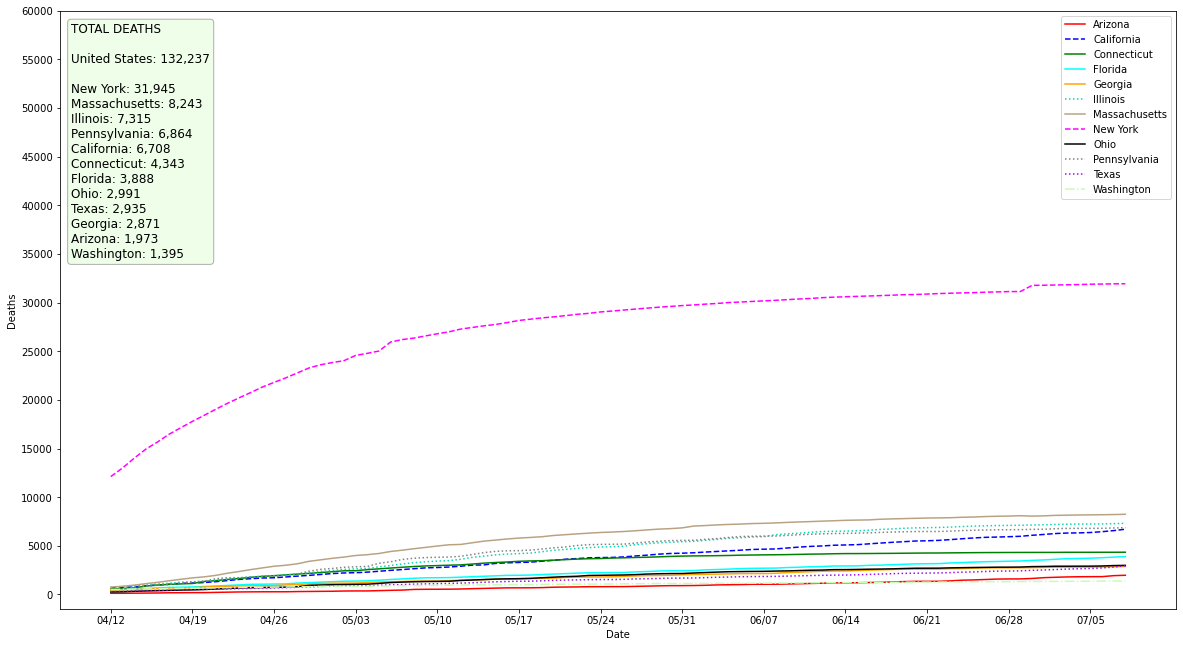

In [29]:
fig, ax = plot_states(nyt_data, STATES_TO_COMPARE, image_file='nyt-states1.png')

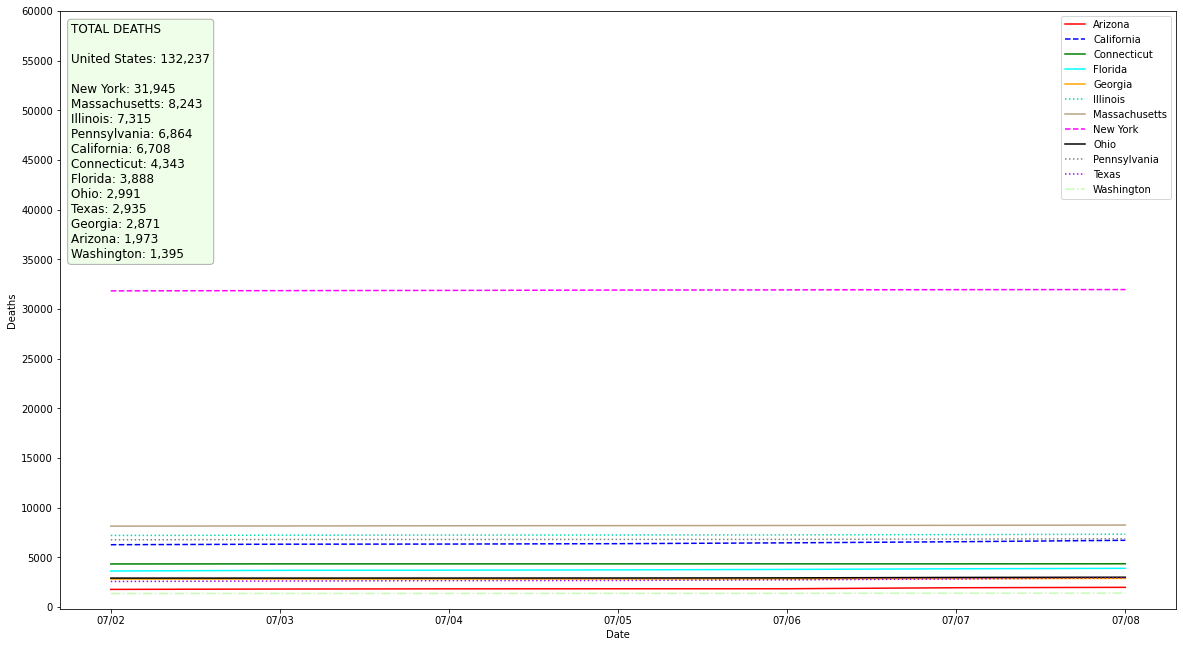

In [30]:
fig, ax = plot_states(nyt_data, STATES_TO_COMPARE, image_file='nyt-states1-last-week.png', start_date=six_days_prior)

### Same states, but without New York

New York, as a hotspot, skews the graph.

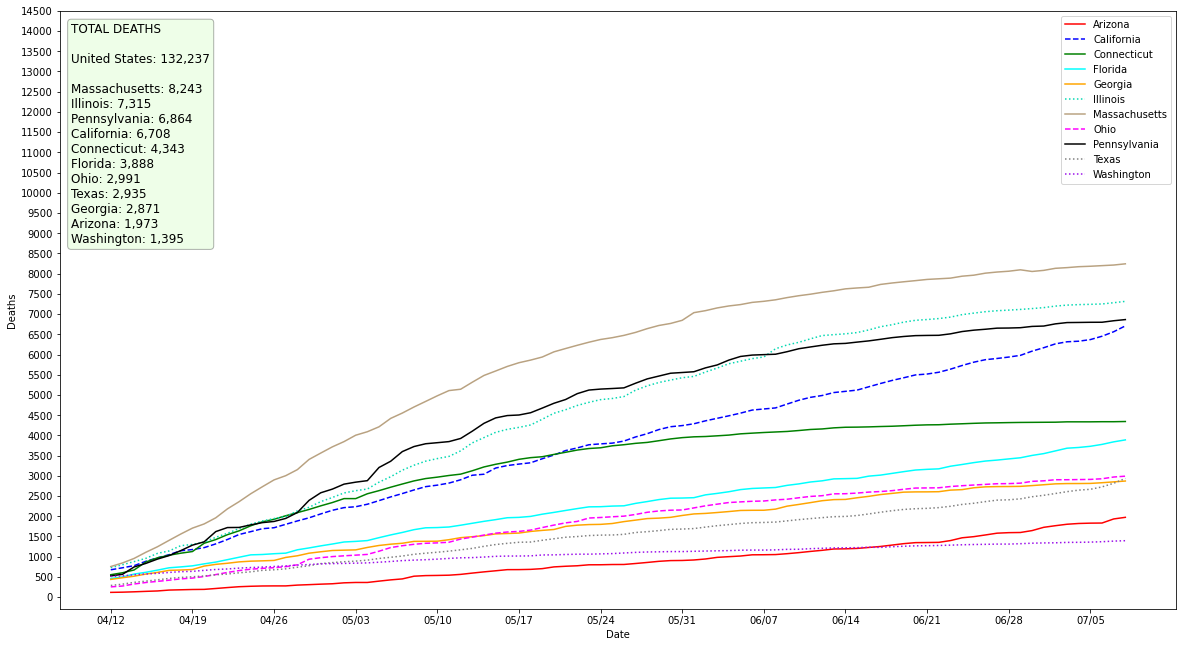

In [31]:
without_ny = sorted(list(set(STATES_TO_COMPARE) ^ set(('New York',))))
fig, ax = plot_states(nyt_data, without_ny, image_file='nyt-states2.png')

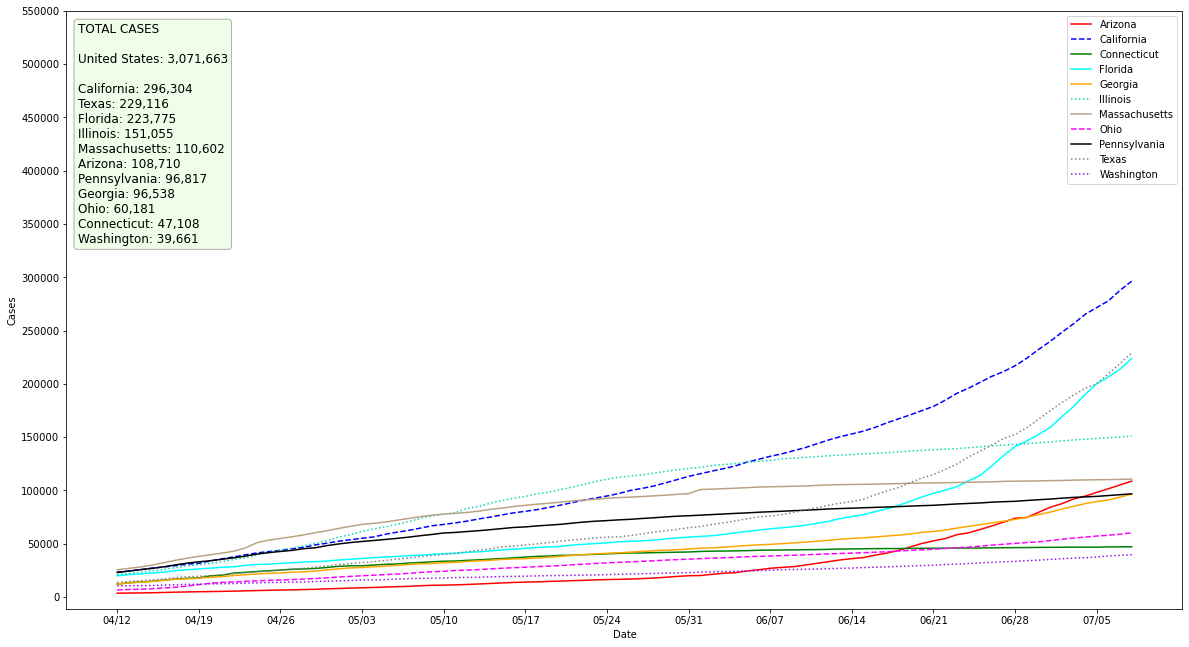

In [32]:
fig, ax = plot_states(nyt_data, without_ny, image_file='nyt-states3.png', metric=MetricType.CASES)

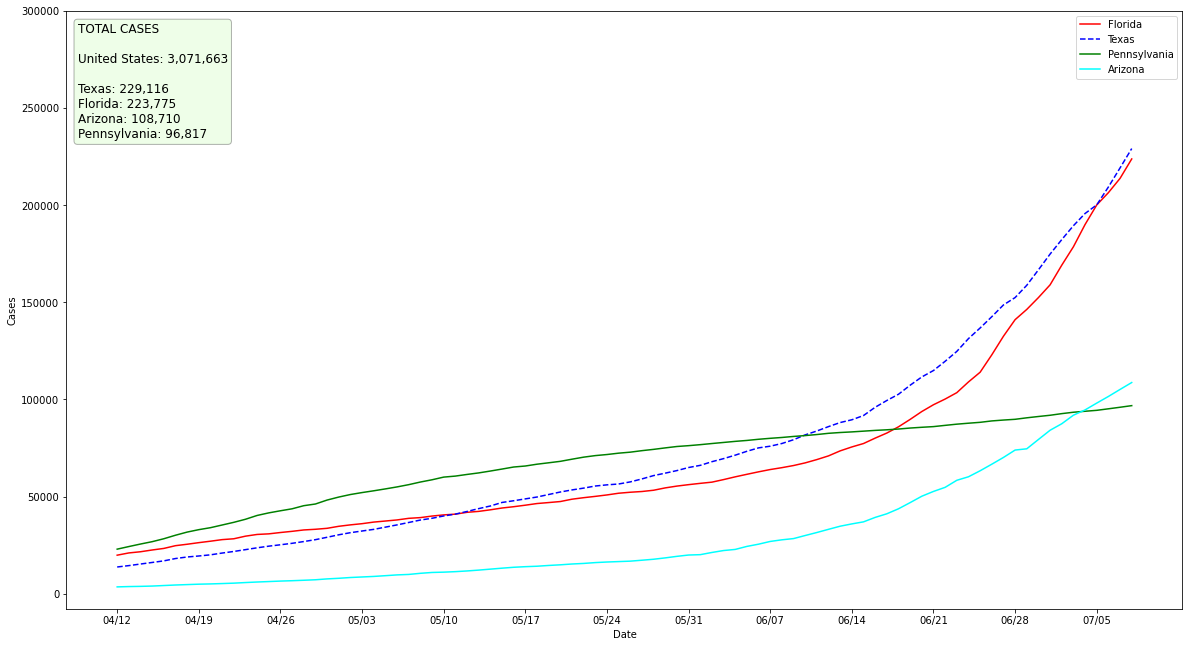

In [33]:
fig, ax = plot_states(nyt_data, ('Florida', 'Texas', 'Pennsylvania', 'Arizona'),
                      image_file='nyt-states4.png', metric=MetricType.CASES)

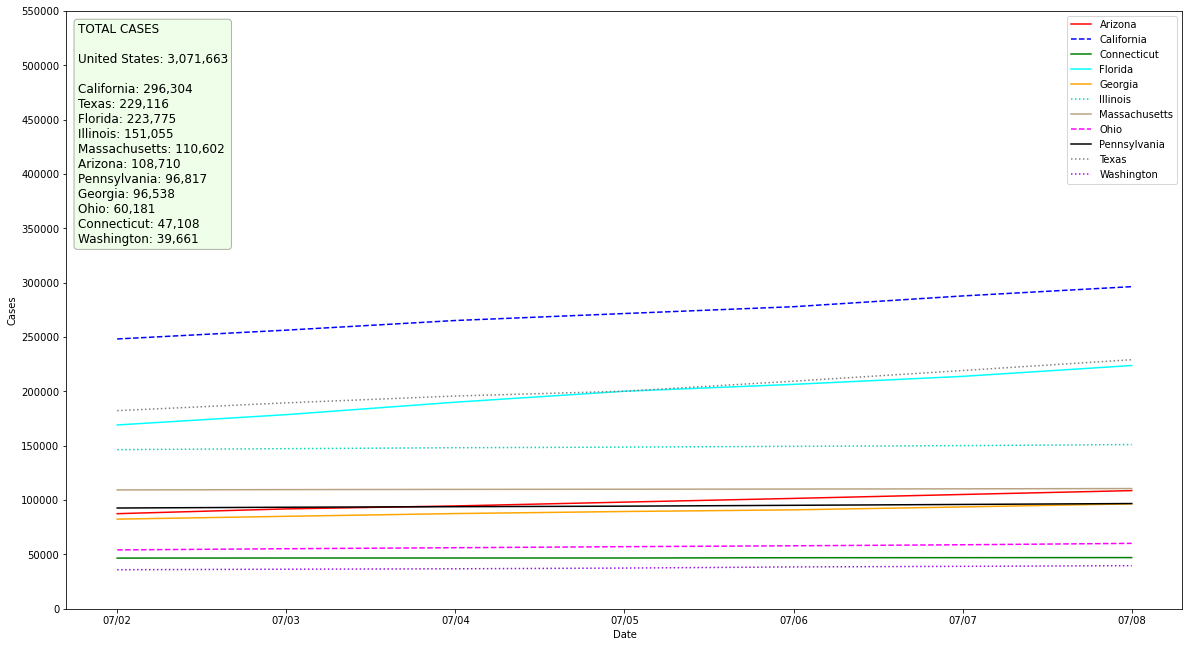

In [34]:
fig, ax = plot_states(nyt_data, without_ny, image_file='nyt-states5.png', metric=MetricType.CASES,
                      start_date=six_days_prior)

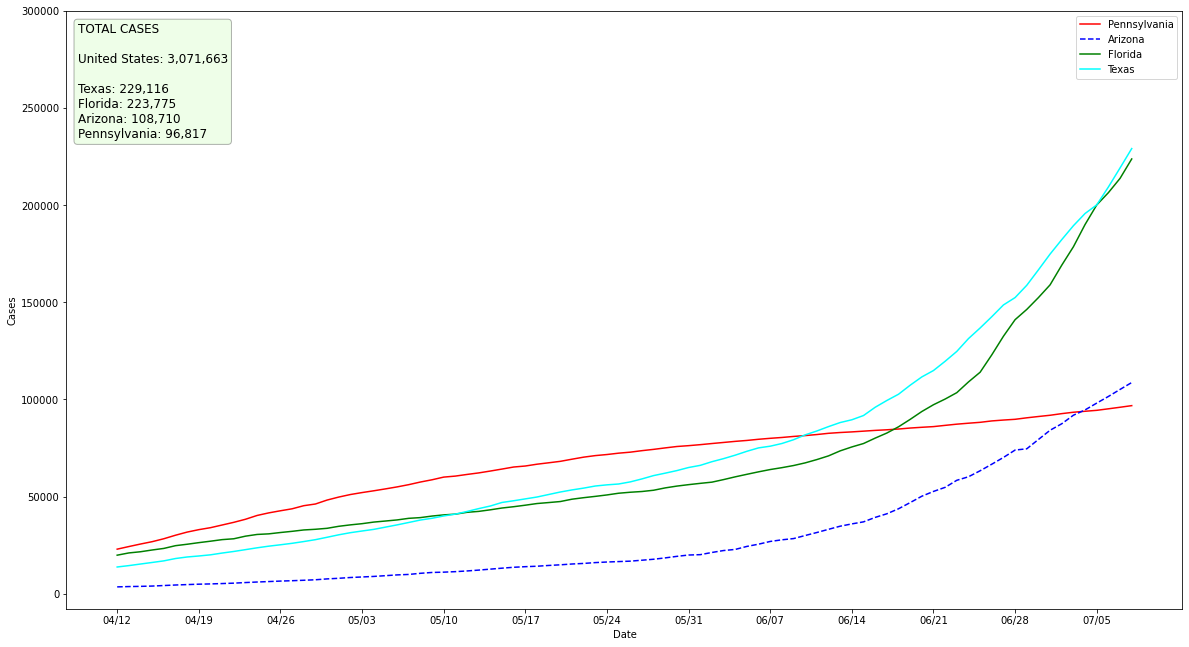

In [35]:
fig, ax = plot_states(nyt_data, ('Pennsylvania', 'Arizona', 'Florida', 'Texas',),
                      image_file='nyt-states6.png', metric=MetricType.CASES)

## Per-capita death rates by state

In [36]:
# First, get the data

max_deaths = 0
max_cases = 0
us_deaths = 0
us_cases = 0
state_per_capita_deaths = dict()
state_per_capita_cases = dict()
state_info = load_state_info()
for state in sorted(populations.keys()):
    if state == 'United States':
        continue

    state_deaths = nyt_data[nyt_ending_date][state].deaths
    state_cases = nyt_data[nyt_ending_date][state].cases
    us_deaths += state_deaths
    us_cases += state_cases
    per_capita_deaths = get_per_capita_value(state_deaths, populations[state], per_n=100_000)
    state_per_capita_deaths[state] = int(round(per_capita_deaths))
    per_capita_cases = get_per_capita_value(state_cases, populations[state], per_n=100_000)
    state_per_capita_cases[state] = int(round(per_capita_cases))
    rounded_up = int(round(per_capita_deaths))
    
us_pop = populations['United States']
us_per_capita_deaths = int(round(get_per_capita_value(us_deaths, us_pop)))
us_per_capita_cases = int(round(get_per_capita_value(us_cases, us_pop)))

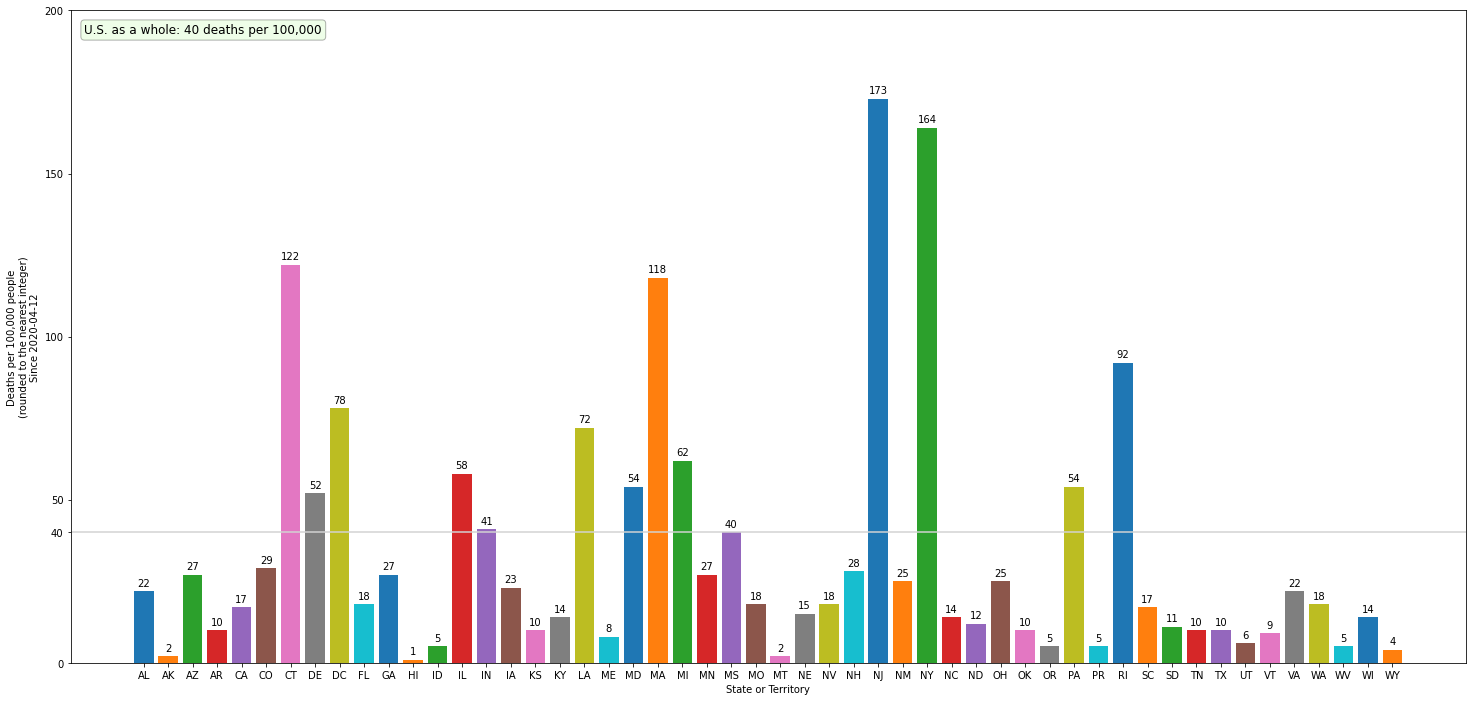

In [37]:
# Deaths

fig, ax = p.subplots(figsize=(25, 12))

bar_labels = []
max_value = 0
for state in sorted(populations.keys()):
    if state == 'United States':
        continue

    abbrev = state_info[state].abbreviation
    value = state_per_capita_deaths[state]
    ax.bar(abbrev, value)
    bar_labels.append(f"{value}")
    max_value = max(max_value, value)
    
ax.axhline(us_per_capita_deaths, color="lightgray")

ymax, stride = determine_ymax_and_stride(max_value)
ax.set_yticks(list(range(0, ymax))[::stride] + [us_per_capita_deaths])
ax.set_ylabel(f'Deaths per 100,000 people\n(rounded to the nearest integer)\nSince {nyt_starting_date}')
ax.set_xlabel('State or Territory')

# See https://stackoverflow.com/a/28931750
for rect, label in zip(ax.patches, bar_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1, label, ha='center', va='bottom')

textbox(ax, 0.01, 0.98, f"U.S. as a whole: {us_per_capita_deaths:,} deaths per 100,000")
fig.savefig(os.path.join(IMAGES_PATH, 'jhu-state-per-capita-deaths.png'))

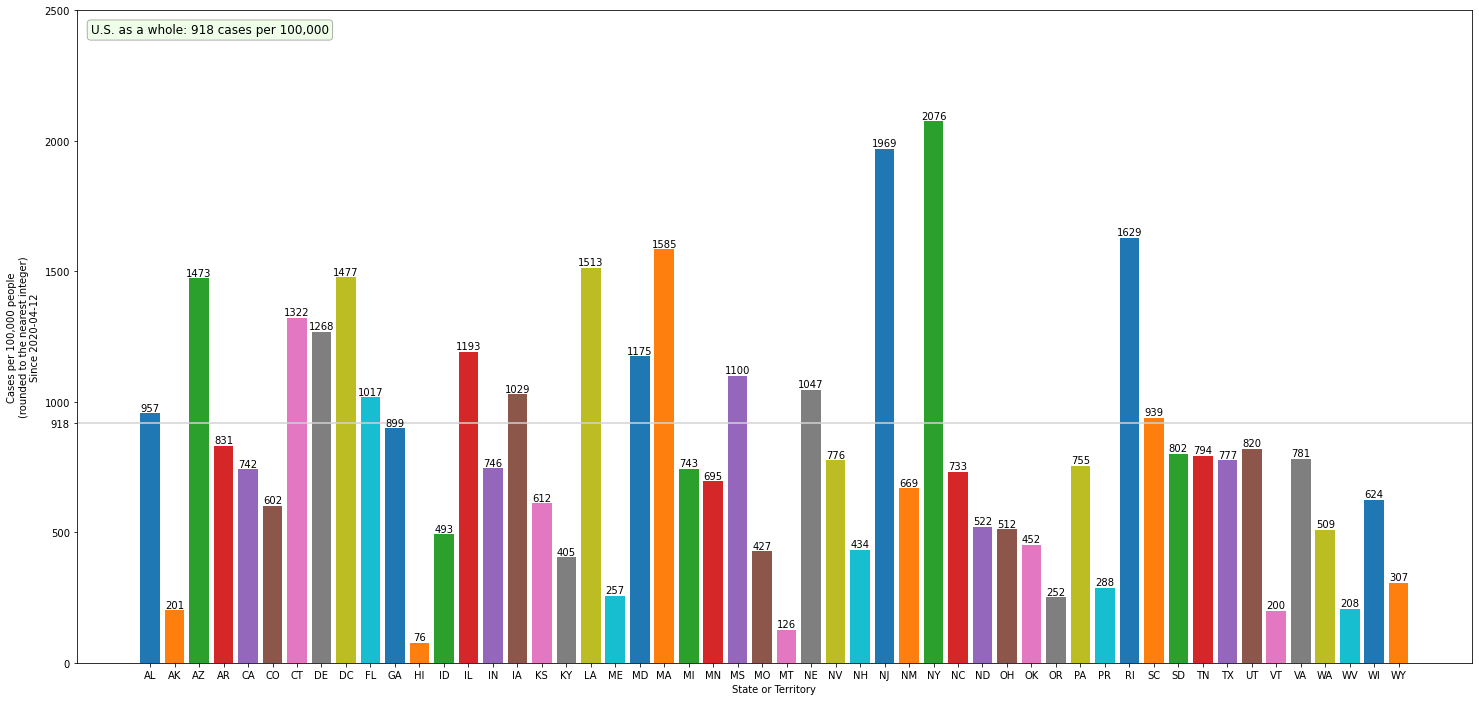

In [38]:
# Cases

fig, ax = p.subplots(figsize=(25, 12))

bar_labels = []
max_value = 0
for state in sorted(populations.keys()):
    if state == 'United States':
        continue

    abbrev = state_info[state].abbreviation
    value = state_per_capita_cases[state]
    ax.bar(abbrev, value)
    bar_labels.append(f"{value}")
    max_value = max(max_value, value)
    
ax.axhline(us_per_capita_cases, color="lightgray")

ymax, stride = determine_ymax_and_stride(max_value)
ax.set_yticks(list(range(0, ymax))[::stride] + [us_per_capita_cases])
ax.set_ylabel(f'Cases per 100,000 people\n(rounded to the nearest integer)\nSince {nyt_starting_date}')
ax.set_xlabel('State or Territory')

# See https://stackoverflow.com/a/28931750
for rect, label in zip(ax.patches, bar_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1, label, ha='center', va='bottom')

textbox(ax, 0.01, 0.98, f"U.S. as a whole: {us_per_capita_cases:,} cases per 100,000")
fig.savefig(os.path.join(IMAGES_PATH, 'jhu-state-per-capita-cases.png'))

## Counties

In [39]:
def plot_county(ax, dates, state_county_data, county, line_color, line_style, metric=MetricType.DEATHS):
    """
    Plot one county on an existing graph. Return the
    total value for that county over the range of dates given.
    """
    if metric not in {MetricType.DEATHS, MetricType.CASES}:
        assert False, f"Can't plot {metric}"

    x_dates = [datestr(d) for d in dates]
    max_total = 0
    total = []
    for date in dates:
        data = state_county_data[date][county]
        if metric == MetricType.CASES:
            total.append(data.cases)
        else:
            total.append(data.deaths)

    max_total = max(max_total, total[-1])
    ax.plot(x_dates, total, color=line_color, label=county, linestyle=line_style)
    if len(dates) > 14:
        ax.set_xticks(x_dates[::7])
    return max_total

def plot_counties(state, counties, dates, metric=MetricType.DEATHS, image_file=None, xy_text=(0.01, 0.98)):
    fig, ax = p.subplots(figsize=(20, 11))
    text_for_each_county = []
    state_county_data = county_data[state]
    for county, line_color, line_style in counties:
        max_total = plot_county(ax, dates, state_county_data, county, line_color, line_style, metric=metric)
        text_for_each_county.append(f'{county}: {max_total:,}')

    cases_or_deaths = str(metric.name).capitalize()
    ax.legend()
    ymax, stride = determine_ymax_and_stride(max_total)

    # Arbitrarily increase ymax, to account for legend.
    ymax = int(round(ymax * 1.5))
    ax.set_yticks(range(0, ymax)[::stride])
    ax.set_xlabel('Date')
    ax.set_ylabel(cases_or_deaths)

    counties_text = '\n'.join(text_for_each_county)
    text = f"""{cases_or_deaths} for select {state} counties

{counties_text}

Source: New York Times"""

    x, y = xy_text

    textbox(ax, x, y, text)
    if image_file is not None:
        fig.savefig(os.path.join(IMAGES_PATH, image_file))


### Some select Pennsylvania counties

In [40]:
pa_counties = (
    ('Adams', 'orange', 'solid'),
    ('Allegheny', 'green', 'solid'),
    ('Bedford', 'xkcd:aquamarine', 'dotted'),
    ('Berks', 'black', 'solid'),
    ('Bucks', 'magenta', 'dashed'),
    ('Chester', 'blue', 'dashed'),
    ('Fulton', 'xkcd:taupe', 'solid'),
    ('Montgomery', 'cyan', 'solid'),
    ('Philadelphia', 'red', 'solid'),
)

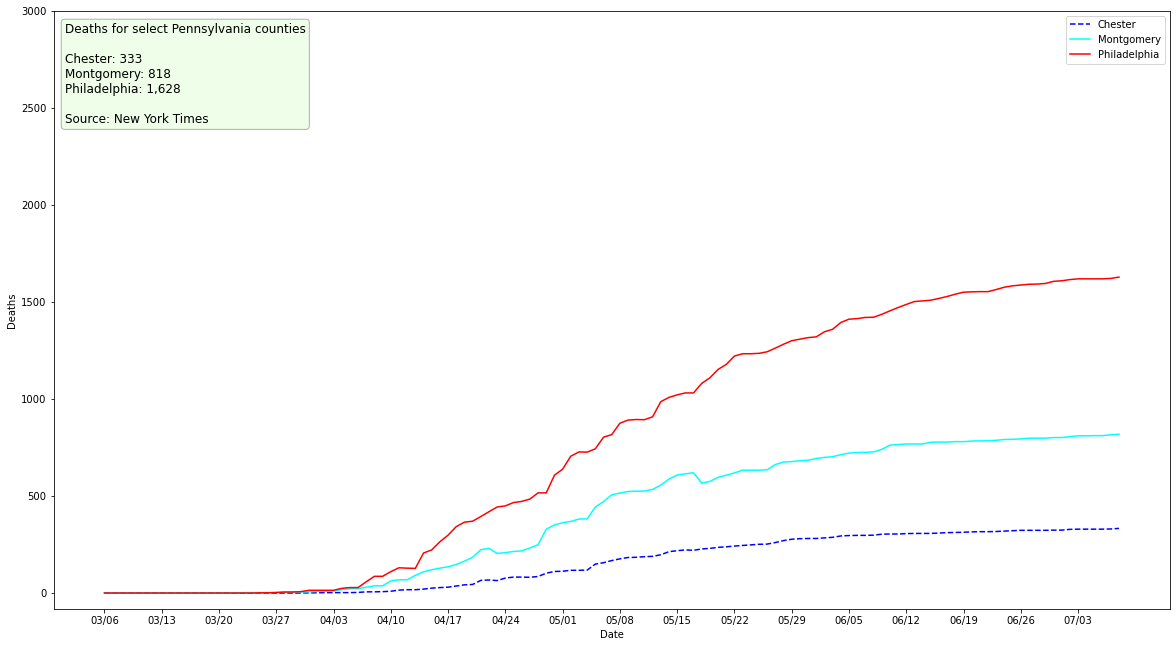

In [41]:
pa_dates = sorted(county_data['Pennsylvania'].keys())
hard_hit_pa = [(county, color, ls) for county, color, ls in pa_counties if county in ('Philadelphia', 'Montgomery', 'Chester')]
plot_counties('Pennsylvania', hard_hit_pa, pa_dates, image_file='nyt-pa-monto-chester-philly.png')

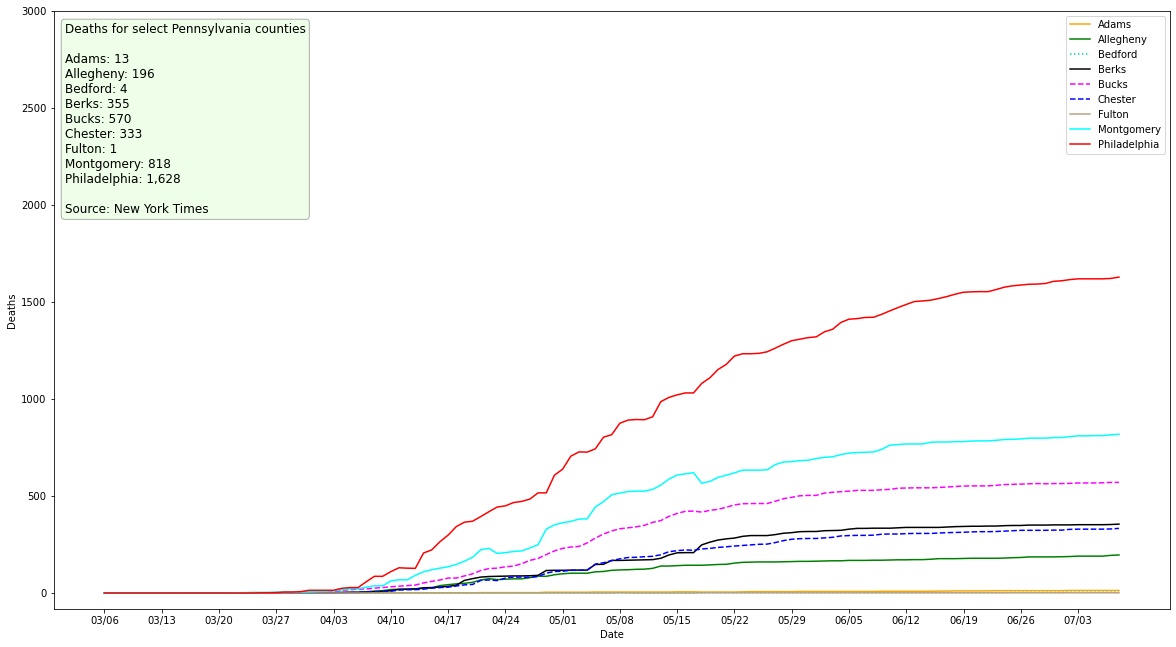

In [42]:
plot_counties('Pennsylvania', pa_counties, pa_dates, image_file='nyt-pa-counties1.png')

In [48]:
last_day = max(pa_dates)
week_ago = last_day - timedelta(days=6)
last_week_days_in_order = sorted(d for d in pa_dates if d >= week_ago)

[datetime.date(2020, 7, 2),
 datetime.date(2020, 7, 3),
 datetime.date(2020, 7, 4),
 datetime.date(2020, 7, 5),
 datetime.date(2020, 7, 6),
 datetime.date(2020, 7, 7),
 datetime.date(2020, 7, 8)]

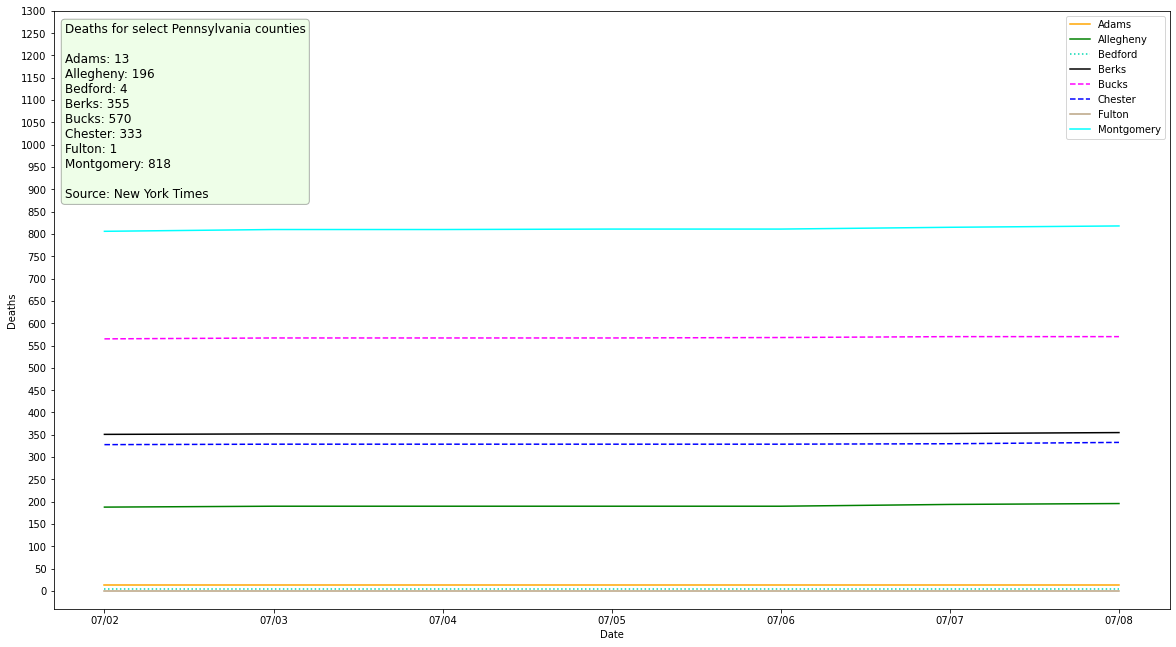

In [49]:
# Take Philly out to better see the others.
counties = [(county, line_color, line_style) for county, line_color, line_style in pa_counties if county != 'Philadelphia']
plot_counties('Pennsylvania', counties, last_week_days_in_order, image_file='nyt-pa-counties2.png')

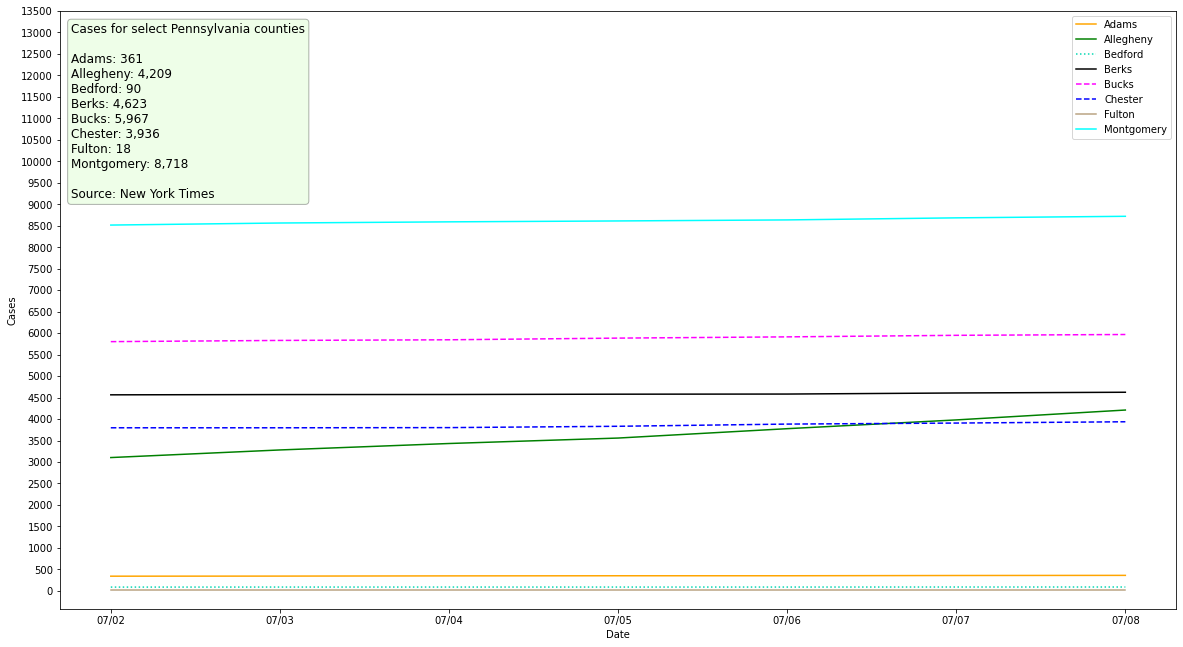

In [50]:
# Take Philly out to better see the others.
counties = [(county, line_color, line_style) for county, line_color, line_style in pa_counties if county != 'Philadelphia']
plot_counties('Pennsylvania', counties, last_week_days_in_order, image_file='nyt-pa-counties2.png', metric=MetricType.CASES)

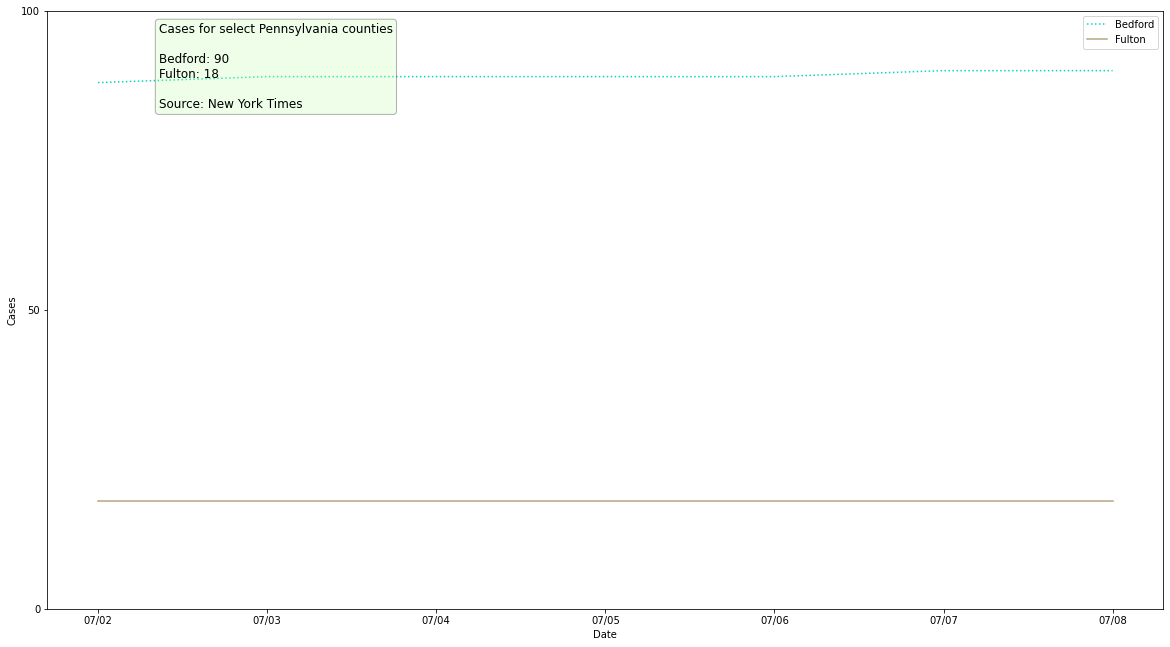

In [51]:
counties = [(county, line_color, line_style) for county, line_color, line_style in pa_counties if county in ('Bedford', 'Fulton')]
plot_counties('Pennsylvania', counties, last_week_days_in_order, image_file='nyt-pa-counties3.png', metric=MetricType.CASES,
              xy_text=(0.1, 0.98))

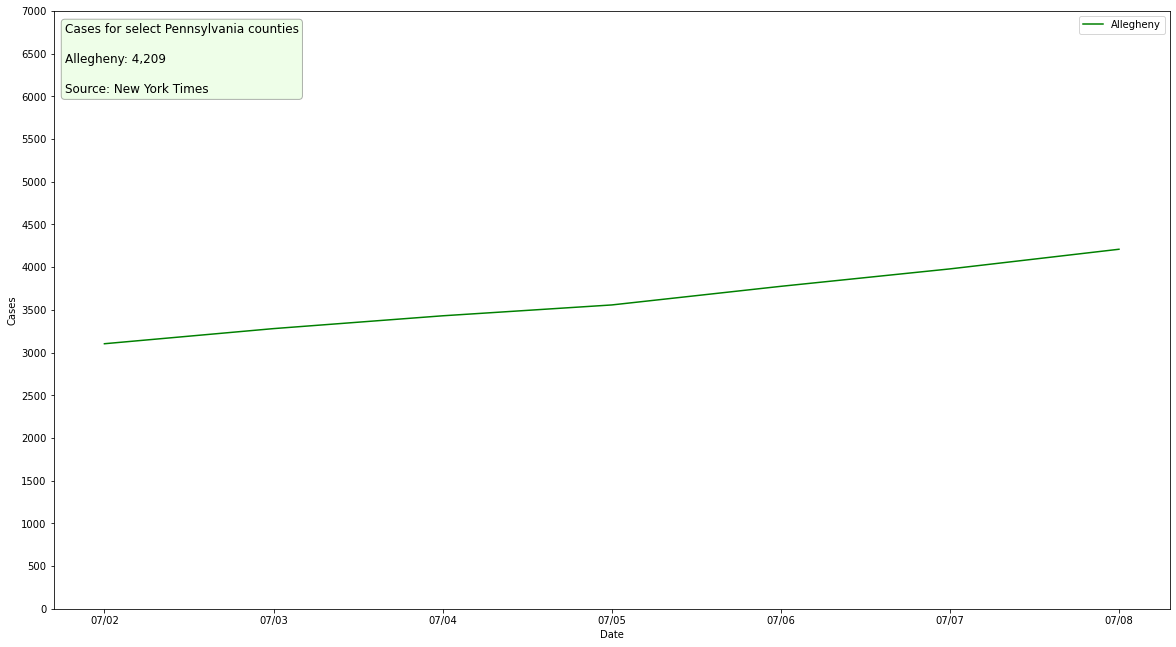

In [59]:
allegheny = [(county, line_color, line_style) for county, line_color, line_style in pa_counties if county == 'Allegheny']
plot_counties('Pennsylvania', allegheny, last_week_days_in_order, image_file='nyt-pa-allegheny.png', metric=MetricType.CASES)

## Florida 

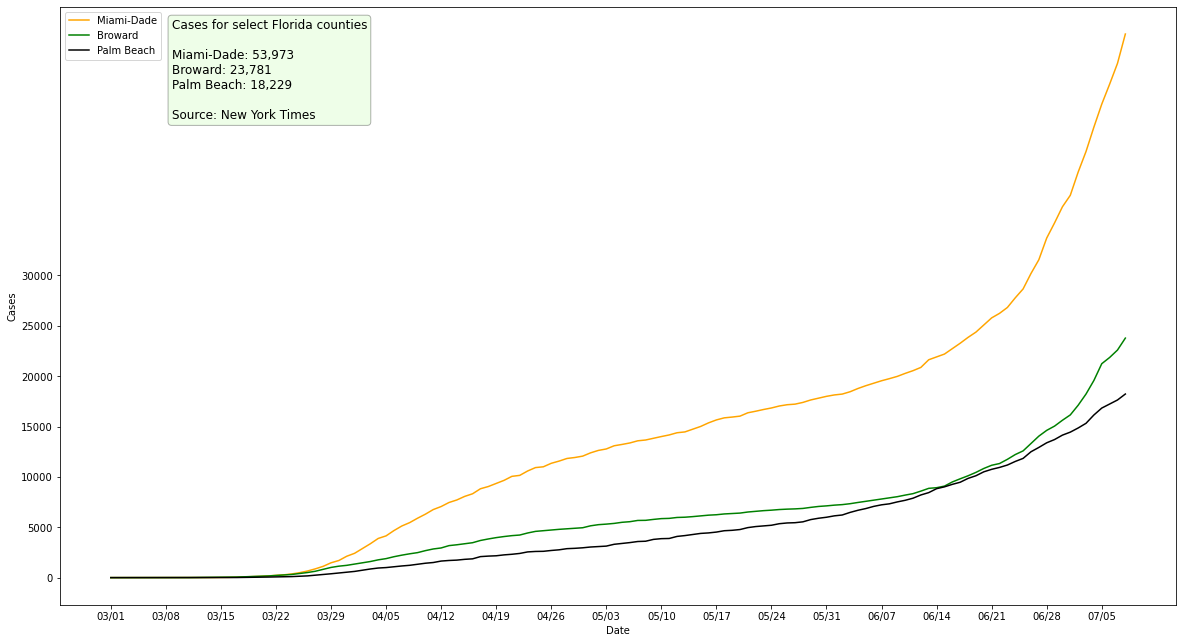

In [54]:
fl_by_county = county_data['Florida']
fl_counties = (
    ('Miami-Dade', 'orange', 'solid'),
    ('Broward', 'green', 'solid'),
    ('Palm Beach', 'black', 'solid'),
)
plot_counties('Florida', fl_counties[:3], sorted(county_data['Florida'].keys()),
              image_file='nyt-fl-miami-dade.png', metric=MetricType.CASES, xy_text=(0.1, 0.98))